# **Proyecto 03**: Sistemas de recomendación

Se va a implementar un **Sistema de Recomendación** para videojuegos de la plataforma Steam. Se van a utilizar dos datasets, uno que compila la información de los distintos videojuegos y otro referido a las críticas.

---
**INICIO**

---
Importamos las distintas librerías que se van a utilizar y los dos datasets.

---
Imports

In [1]:
import datetime
import gzip
import itertools
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import re
import seaborn as sns

from implicit import evaluation
from implicit.als import AlternatingLeastSquares

from jupyterthemes import jtplot

from scipy import sparse
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import RobustScaler
from sklearn.utils.random import sample_without_replacement

#jtplot.style(theme='gruvboxd')

---
Función *parse*

---

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## **Datasets**

Como se comento al principio, se trabajará con dos dataset distintos. Uno corresponde a las críticas y otro a los datos de los juegos.

El primer paso es cargar los mismos en memoria para tener un primer acercamiento a nuestros datos. Se sabe de ante mano que el tamaño de los mismos es algo que se debe tener en cuenta.

### Reviews

Importamos parte del dataset de las críticas. Analizamos en esta sección el dataset que contiene las críticas de los usuarios.

In [3]:
contador = 0
data_reviews = []

# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n=3,
# abrira uno de cada tres, y así.
n = 2
reviews_dir = '..\Proyecto III\steam_reviews.json.gz'
for l in parse(reviews_dir):
    if contador%n == 0:
        data_reviews.append(l)
    #else:
        #pass
    contador += 1

Analizamos los dataset para ver con que nos encontramos. Mostramos cinco registros al azar.

In [5]:
# Seleccionamos algunas columnas para mejorar los tiempos de procesamiento
columns=['username', 'hours', 'products', 'date', 'text', 'early_access', 'product_id']
reviews = pd.DataFrame(data_reviews, columns=columns)
mapper = { 'username': 'Usuario', 'hours': 'Cant. horas', 'products' : 'Cant. juegos', 'date': 'Fecha',
           'text': 'Comentario', 'early_access': 'Preview', 'product_id': 'GameID' }
reviews.rename(columns=mapper, inplace=True)
del data_reviews

In [4]:
reviews = pd.DataFrame(data_reviews)
del data_reviews
reviews.sample(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
3775222,Alpha MALE,2.1,56.0,221100,7,2017-07-16,doodoo kaka,True,478,NaN,NaN,NaN
3884963,The Third Teacher,27.5,69.0,252490,7,2014-06-25,9/10 with friends,True,7907,NaN,NaN,76561198029515668
2064713,Trackblock,1.7,167.0,312370,3,2014-11-26,So I was looking forward to a turn-based 40K g...,False,35,NaN,NaN,76561197970532681
2507588,Galyndean,1.3,199.0,299680,0,2017-03-18,Let's be real. You can set aside an hour and ...,False,6,NaN,NaN,NaN
2104285,oi_jeff,24.0,45.0,268910,0,2017-11-01,ohh soo goood!,False,736,NaN,NaN,NaN


Visualizamos un resumen de nuestro dataset.

In [7]:
print(f'Shape: { reviews.shape }')
reviews.info()

Shape: (3896535, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896535 entries, 0 to 3896534
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   products      float64
 3   product_id    object 
 4   page_order    int64  
 5   date          object 
 6   text          object 
 7   early_access  bool   
 8   page          int64  
 9   found_funny   float64
 10  compensation  object 
 11  user_id       object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 330.7+ MB


Como se visualiza, contamos con **3.896.535 registros** junto a **12 columnas**. A su vez, estamos ocupando más de **330 mb.** en memoria por lo que, al momento de realizar distintas consultas y análisis, vamos a notar bastante demora. Estás apreciaciones las realizo teniendo en cuenta las capacidades de mi PC.

Visualizamos las distintas columnas y extraemos las más importantes para nuestro análisis.

In [12]:
column = '\t | '
for name in reviews.columns:
    column += f'{ name } | '
print('Los nombres de columnas del dataset son:')
print(column)

Los nombres de columnas del dataset son:
	 | username | hours | products | product_id | page_order | date | text | early_access | page | found_funny | compensation | user_id | 


In [5]:
reviews.drop(columns=['compensation', 'page_order', 'page', 'user_id'], inplace=True)
mapper = { 'username': 'Usuario', 'hours': 'Cant. horas', 'products' : 'Cant. juegos',
           'found_funny': 'Divertido?', 'date': 'Fecha', 'text': 'Comentario', 'early_access': 'Preview',
           'product_id': 'GameID' }
reviews.rename(columns=mapper, inplace=True)
reviews = reviews.reindex(columns=['Usuario', 'Cant. horas', 'Cant. juegos', 'Fecha', 'Comentario', 'Preview',
                                   'Divertido?', 'GameID'])
reviews.head()

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,Divertido?,GameID
0,Chaos Syren,0.1,41.0,2017-12-17,This would not be acceptable as an entertainme...,False,NaN,725280
1,hello?<,14.6,2.0,2017-10-16,Better than Minecraft,False,2.0,328100
2,DarklyThinking,16.6,577.0,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,NaN,35140
3,nd,1.0,2759.0,2017-11-28,"endless rooms of some underground complex, blo...",False,1.0,725280
4,jimllfixitok,1.1,729.0,2017-10-16,no sound. icons don't work. re-installed but n...,False,NaN,707610


Nuestro dataset es más claro y legible al momento de visualizar los registros. Visualizamos el porcentaje de valores nulos.

Las siguientes columnas tienen valores nulos:
	Cant. horas tiene 13206 datos nulos (0.34%).
	Cant. juegos tiene 7531 datos nulos (0.19%).
	Divertido? tiene 3296831 datos nulos (84.61%).



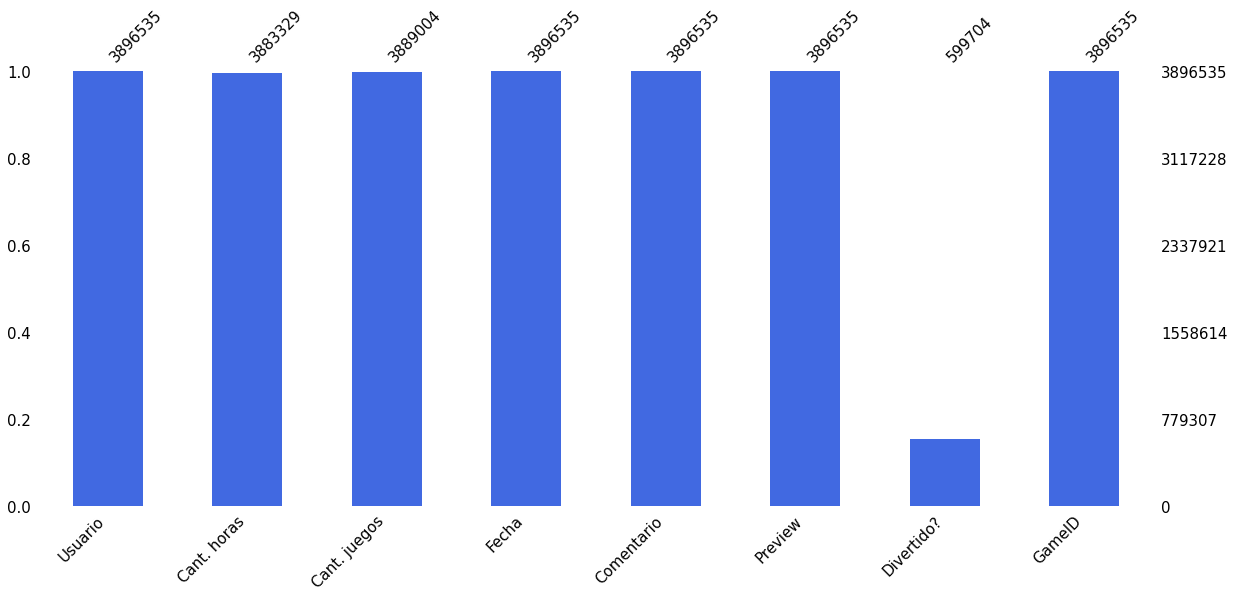

In [7]:
column = ''
for i in reviews.columns:
    if reviews[i].isna().sum() > 0:
        #isna_count = properati[i].isna().sum()
        cantidad = reviews[i].isna().sum()
        total = len(reviews)
        porcentaje = round(100*cantidad/total, 2)
        column += f'\t{ i } tiene { reviews[i].isna().sum() } datos nulos ({ porcentaje }%).\n'
print('Las siguientes columnas tienen valores nulos:')
print(column)

msno.bar(reviews, figsize=(20,8), fontsize=15, color='Royalblue')
plt.show()

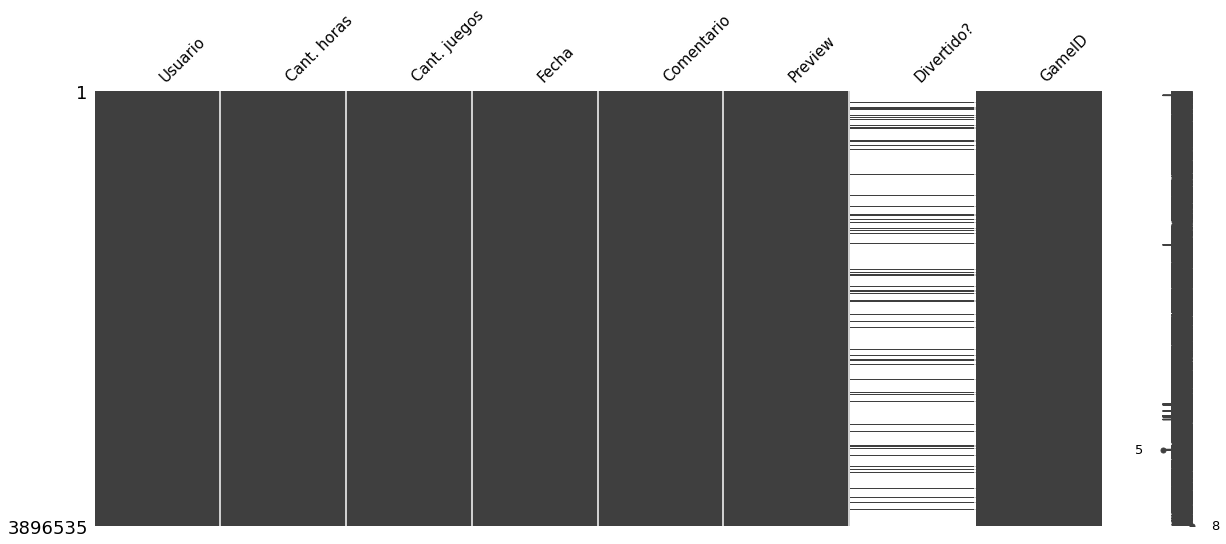

In [11]:
msno.matrix(reviews, figsize=(20,8), fontsize=15)
plt.show()

Como se puede observar, existen valores nulos en nuestro dataset. Se destaca la proporción de datos nulos que tiene el atributo `Divertido?`, más del 80% está incompleto y es la valoración que tienen los usuario sobre el juego luego de haber pasado x cantidad de horas jugando en el mismo.

Debido a la cantidad de datos nulos en dicho atributo, procedemos a eliminar el mismo.

In [12]:
reviews.drop(columns='Divertido?', inplace=True)

### Games

Finalizado este primer acercamiento con el dataset de críticas, importamos nuestros datos que contienen información sobre los juegos.

In [6]:
data_games = []
games_dir = '..\Proyecto III\steam_games.json.gz'
for games in parse(games_dir):
    data_games.append(games)
#games = pd.read_json(games_dir, compression='gzip', lines=False, orient='split', typ='series')

Analizamos el dataset de videojuegos, mostramos cinco registros al azar.

In [7]:
# Seleccionamos algunas columnas para mejorar los tiempos de procesamiento
columns = ['id', 'app_name', 'developer', 'title', 'release_date', 'genres', 'specs', 'tags', 'url',
           'early_access', 'price', 'sentiment']
games = pd.DataFrame(data_games, columns=columns)
mapper = { 'id': 'GameID', 'app_name': 'Aplicación', 'developer': 'Desarrollador',
           'release_date': 'Fecha lanzamiento', 'genres': 'Géneros', 'specs': 'Especificaciones',
           'tags': 'Etiquetas', 'url': 'Url', 'early_access': 'Acceso previo', 'price': 'Precio',
           'sentiment': 'Sentimiento' }
games.rename(columns=mapper, inplace=True)
games = games.reindex(columns=['GameID', 'Aplicación', 'Desarrollador', 'Fecha lanzamiento', 'Géneros',
                               'Especificaciones', 'Etiquetas', 'Url', 'Acceso previo', 'Precio',
                               'Sentimiento'])
del data_games

In [14]:
games = pd.DataFrame(data_games)
del data_games
games.sample(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
6977,NaN,[Indie],Just Bones - Just Bonus Track,Just Bones - Just Bonus Track,http://store.steampowered.com/app/515990/Just_...,2016-08-17,[Indie],NaN,http://steamcommunity.com/app/515990/reviews/?...,"[Single-player, Downloadable Content, Steam Ac...",Free,False,515990,Elephant Games,NaN,NaN
12310,Salus Games,"[Casual, Indie]",Layers,Layers,http://store.steampowered.com/app/661330/Layers/,2017-11-13,"[Indie, Casual, Singleplayer, Puzzle, Puzzle-P...",NaN,http://steamcommunity.com/app/661330/reviews/?...,"[Single-player, Steam Achievements, Steam Work...",0.99,False,661330,Salus Games,NaN,NaN
32097,Lunar Giant Studios,"[Action, Indie]",Tetrapulse,Tetrapulse,http://store.steampowered.com/app/250440/Tetra...,2016,"[Indie, Action, Co-op]",NaN,http://steamcommunity.com/app/250440/reviews/?...,"[Multi-player, Co-op, Shared/Split Screen, Ste...",NaN,False,250440,The Amiable,NaN,NaN
2246,Libredia,[Racing],HTR+ Slot Car Simulation,HTR+ Slot Car Simulation,http://store.steampowered.com/app/288650/HTR_S...,2014-05-29,"[Racing, Simulation]",NaN,http://steamcommunity.com/app/288650/reviews/?...,"[Single-player, Partial Controller Support]",6.99,False,288650,QUByte Interactive,Mostly Positive,NaN
16084,Vagabond Dog,"[Casual, Indie, Sports]",DOG GONE GOLFING,DOG GONE GOLFING,http://store.steampowered.com/app/665590/DOG_G...,2017-08-25,"[Sports, Casual, Indie, Pixel Graphics]",NaN,http://steamcommunity.com/app/665590/reviews/?...,"[Single-player, Local Multi-Player, Shared/Spl...",1.99,False,665590,Vagabond Dog,1 user reviews,NaN


Visualizamos un resumen de nuestro dataset.

In [12]:
print(f'Shape: { games.shape }')
games.info()

Shape: (32135, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


En este dataset contamos con 32.135 registros junto a 16 columnas. Visualizamos las distintas columnas y extraemos las más importantes para nuestro análisis.

In [152]:
column = '\t | '
for name in games.columns:
    column += f'{ name } | '
print('Los nombres de columnas del dataset son:')
print(column)

Los nombres de columnas del dataset son:
	 | publisher | genres | app_name | title | url | release_date | tags | discount_price | reviews_url | specs | price | early_access | id | developer | sentiment | metascore | 


In [15]:
columns = ['id', 'app_name', 'developer', 'title', 'release_date', 'genres', 'specs', 'tags', 'url',
           'early_access','sentiment', 'metascore']
games.drop(columns=['discount_price', 'publisher', 'reviews_url', 'title'], inplace=True)

mapper = { 'id': 'GameID', 'app_name': 'Aplicación', 'developer': 'Desarrollador',
           'release_date': 'Fecha lanzamiento', 'genres': 'Géneros', 'specs': 'Especificaciones',
           'tags': 'Etiquetas', 'url': 'Url', 'early_access': 'Acceso previo', 'price': 'Precio',
           'sentiment': 'Sentimiento', 'metascore': 'Metascore' }
games.rename(columns=mapper, inplace=True)
games = games.reindex(columns=['GameID', 'Aplicación', 'Desarrollador', 'Fecha lanzamiento', 'Géneros',
                               'Especificaciones', 'Etiquetas', 'Url', 'Acceso previo', 'Precio', 'Sentimiento',
                               'Metascore'])
games.head()

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
0,761140,Lost Summoner Kitty,Kotoshiro,2018-01-04,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",http://store.steampowered.com/app/761140/Lost_...,False,4.99,NaN,NaN
1,643980,Ironbound,Secret Level SRL,2018-01-04,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",http://store.steampowered.com/app/643980/Ironb...,False,Free To Play,Mostly Positive,NaN
2,670290,Real Pool 3D - Poolians,Poolians.com,2017-07-24,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",http://store.steampowered.com/app/670290/Real_...,False,Free to Play,Mostly Positive,NaN
3,767400,弹炸人2222,彼岸领域,2017-12-07,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",http://store.steampowered.com/app/767400/2222/,False,0.99,NaN,NaN
4,773570,Log Challenge,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",http://store.steampowered.com/app/773570/Log_C...,False,2.99,NaN,NaN


Luego de descartar las columnas que no nos sirven, analizamos los valores nulos.

Las siguientes columnas tienen valores nulos:
	GameID tiene 2 datos nulos (0.01%).
	Aplicación tiene 2 datos nulos (0.01%).
	Desarrollador tiene 3299 datos nulos (10.27%).
	Fecha lanzamiento tiene 2067 datos nulos (6.43%).
	Géneros tiene 3283 datos nulos (10.22%).
	Especificaciones tiene 670 datos nulos (2.08%).
	Etiquetas tiene 163 datos nulos (0.51%).
	Precio tiene 1377 datos nulos (4.29%).
	Sentimiento tiene 7182 datos nulos (22.35%).
	Metascore tiene 29458 datos nulos (91.67%).



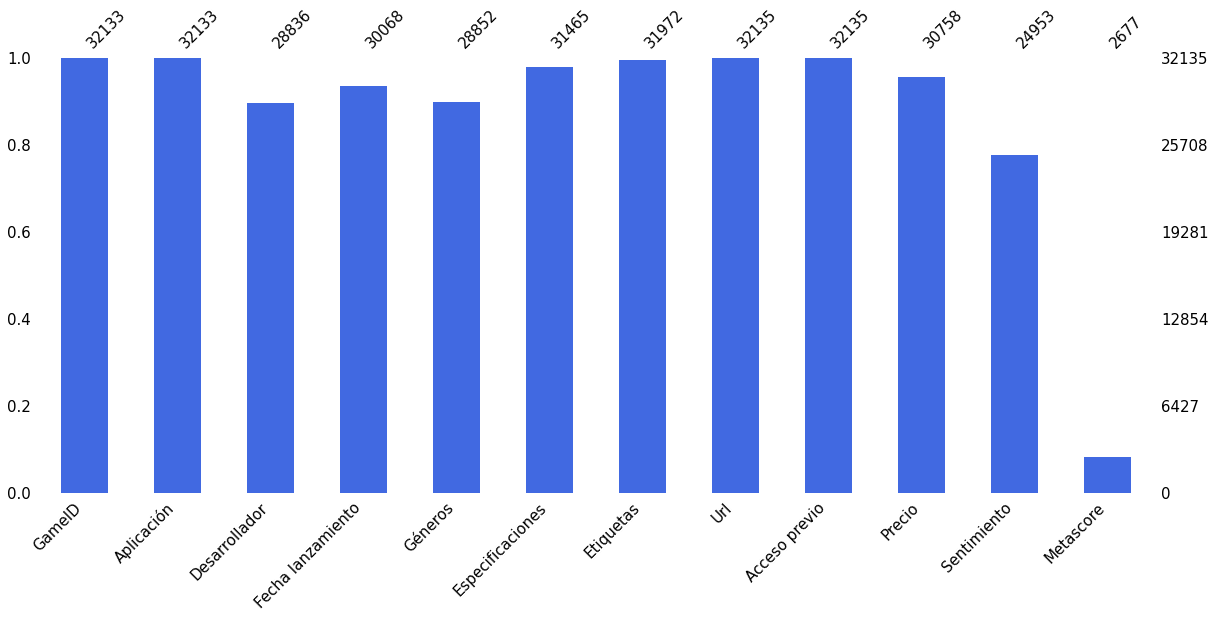

In [16]:
column = ''
for i in games.columns:
    if games[i].isna().sum() > 0:
        #isna_count = properati[i].isna().sum()
        cantidad = games[i].isna().sum()
        total = len(games)
        porcentaje = round(cantidad*100/total, 2)
        column += f'\t{ i } tiene { games[i].isna().sum() } datos nulos ({ porcentaje }%).\n'
print('Las siguientes columnas tienen valores nulos:')
print(column)

msno.bar(games, figsize=(20,8), fontsize=15, color='Royalblue')
plt.show()

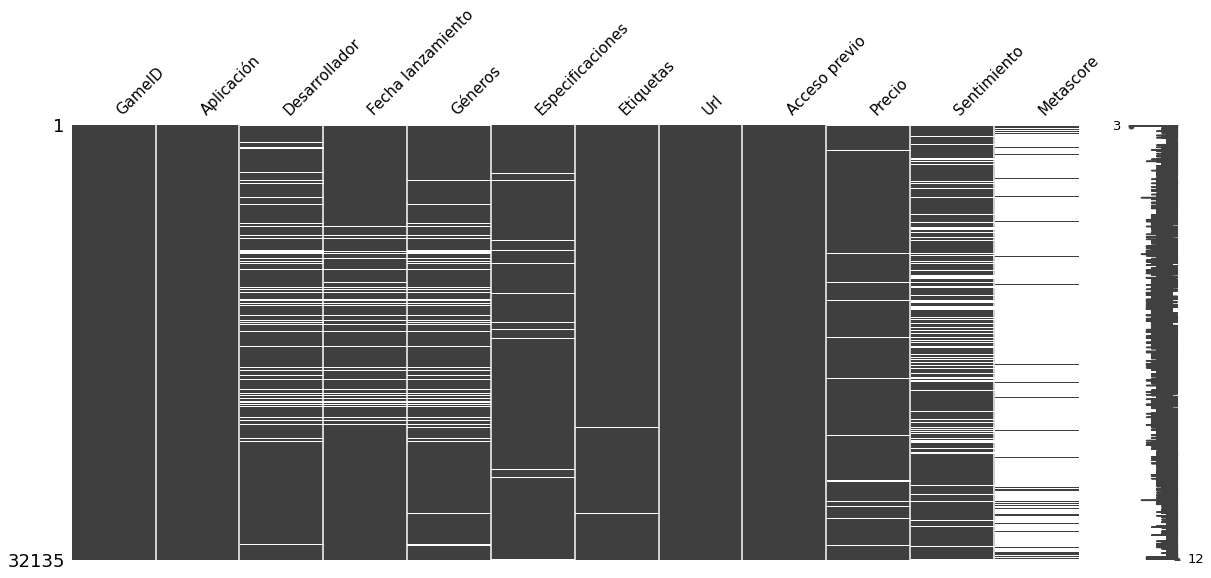

In [17]:
msno.matrix(games, figsize=(20,8), fontsize=15)
plt.show()

Como se puede observar, existe mucha presencia de valores faltantes. El atributo ```Metascore``` tiene más del 90% de los registros como valores nulos y el atributo ```Sentimiento``` posee más del 20%.

In [18]:
games.drop(columns='Metascore', inplace=True)

In [8]:
sns.set_style('whitegrid')

## **Preprocesamiento**

El dataset correspondiente a la información de los videojuegos es el que necesita un preprocesamiento en los datos y el dataset de los comentarios no presenta mayores problemas. De todos modos se hacen algunos ajustes en el mismo.

### Reviews

#### Duplicados

En esta sección vamos a analizar tanto la presencia de registros duplicados como la presencia de varios comentarios (más de uno) que un mismo usuario realiza sobre un juego. En primer lugar, buscamos los registros duplicados y analizamos los mismos.

In [15]:
mask = reviews.duplicated()
reviews[mask].sample(5)

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
3267525,Xyvos,0.4,44.0,2014-07-09,Terrible...But I still love it.\n10/10,False,221640
1546228,nrrdy,14.1,54.0,2015-06-17,The best game I ever played!,False,620
3185154,Lamanunez,18.3,32.0,2017-03-06,Bought the game casue it was on sale and thoug...,False,213670
123006,Biebersan,279.1,86.0,2017-09-04,"Shiiiiiiieeeet negro, best game ever.",False,48700
919305,Hypersomnia,6.6,38.0,2017-01-02,"Playing Bastion is one hell of a ride.\nSo, wh...",False,107100


In [16]:
print(f'Existen { reviews[mask].shape[0] } registros duplicados.')

Existen 215303 registros duplicados.


Como se puede observar, existen **215.303 datos duplicados** en nuestro dataset. Investigamos un usuario al azar.

In [17]:
name = 'Kabuto'
reviews.query('Usuario == @name')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
2458289,Kabuto,27.3,260.0,2017-09-12,"Very fun game, good variety of characters all ...",False,402570
3433850,Kabuto,28.3,32.0,2015-09-09,Best COD ever created,False,10180
3433938,Kabuto,28.3,32.0,2015-09-09,Best COD ever created,False,10180


Como se observa, existen *dos comentarios que realizó el usuario **Kabuto** sobre el juego 10.180*, también se verifica que la fecha como el comentario realizado es el mismo. Eliminamos los duplicados y vemos cantidad de usuarios y de juegos a analizados.

In [9]:
reviews.drop_duplicates(inplace=True)
print('Registros finales:', reviews.shape[0])
print("Total de juegos:", reviews.GameID.value_counts().count())
print("Total de usuarios:", reviews.Usuario.value_counts().count())

Registros finales: 3681232
Total de juegos: 14970
Total de usuarios: 1716724


---
COMENTARIOS DUPLICADOS

---

Como se observó previamente, existían registros duplicados. Si realizamos la misma búsqueda de registros duplicados, pero, solamente teniendo en cuenta los usuarios y el juego, nos vamos a encontrar con lo siguiente:

In [19]:
mask = reviews.duplicated(subset=['Usuario', 'GameID', 'Preview'])
print(f"Existen { reviews[mask].shape[0] } comentarios que un usuario realizó en un mismo videojuego.")
reviews[mask].sample(5)

Existen 25554 comentarios que un usuario realizó en un mismo videojuego.


,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
886917,Ghost,56.0,133.0,2014-12-18,8.5/10 good game. worth for what i paid,False,235600
3671037,Joe,13.3,1142.0,2014-06-15,"This game is fantastic. It's slick, stylish an...",False,220440
99899,Tom,57.2,53.0,2017-06-26,"I bought a PC so I could play GTA V with mods,...",False,271590
678388,Andrew,48.8,47.0,2014-10-14,i got the techdemo of this gmae and played it ...,False,263280
723783,V1P3R,2.2,20.0,2017-12-22,Civ 5 was better. Way to downgrade.,False,289070


Tomamos un usuario al azar y corroboramos que el mismo usuario comento más de una vece un videojuego.

In [20]:
name = 'Ori'
reviews.query('Usuario == @name & GameID == "261570"')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
1219825,Ori,15.2,40.0,2016-12-02,best game i habe played .,False,261570
1279710,Ori,12.6,151.0,2015-06-25,Best 2D Jump n Run Game. Period!\n!!!!! Forlor...,False,261570


En estos casos, la metodología que se eligió fue eliminar aquellos comentarios que sean más antiguos, de este modo, nos quedamos con el último comentario realizado por el usuario, osea, nos quedamos con la última impresión del usuario sobre el juego.

In [10]:
reviews = reviews.sort_values(by='Fecha', ascending=False).drop_duplicates(subset=['Usuario', 'GameID'])

Verificamos el resultado con el usuario **Ori** y el mismo juego **261.570**.

In [22]:
name = 'Ori'
reviews.query('Usuario ==  @name & GameID == "261570"')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
1219825,Ori,15.2,40.0,2016-12-02,best game i habe played .,False,261570


Finalmente, visualizamos la cantidad de registros.

In [23]:
print('Registros finales:', reviews.shape[0])

Registros finales: 3654720


#### Valores faltantes

Respecto a los valores faltantes de nuestro dataset correspondiente a las críticas, se procede directamente a la eliminación de aquellos registros nulos. 

De un universo de 3.896.535 registros, sólo 20.737 tienen valores faltantes entre las columnas `Cant. horas` y `Cant. juegos`; la eliminación de los mismos no implica una pérdida de datos significativa. 

In [24]:
prueba = reviews.copy()
prueba.isna().sum()

Usuario             0
Cant. horas     13018
Cant. juegos     7113
Fecha               0
Comentario          0
Preview             0
GameID              0
dtype: int64

Una solución para abordar el problema de valores faltantes podría ser el relleno de los mismos con el promedio de horas jugadas. Podríamos hacer algo así:

In [25]:
prueba['Cant. horas'].fillna(prueba.groupby('Usuario')['Cant. horas'].transform('mean'), inplace=True)

De todos modos, podemos observar que no se realizaron algunas imputaciones.

In [26]:
prueba.query('`Cant. horas`.isna()', engine='python').sample(5)

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
2264398,pray # laleagane.ro,NaN,171.0,2015-06-26,Foarte interesant !\nMultumesc,False,380890
2923126,Darkghost154,NaN,155.0,2015-05-28,Most epic movie ever,False,374570
425721,SNTRY [IM9],NaN,84.0,2016-05-30,"Its good, really good. Don't approach it like ...",False,353370
424682,jut1988,NaN,137.0,2016-06-02,There is a bit of a learning curve but once yo...,False,353370
432181,seventhfloor,NaN,96.0,2016-04-01,The learning/familiarity curve does exist (eve...,False,353370


In [27]:
prueba.loc[3586231, :]

Usuario           [bic]CaptainMiller
Cant. horas                      NaN
Cant. juegos                   202.0
Fecha                     2011-02-12
Comentario      Direct-Tank-Control!
Preview                        False
GameID                         20540
Name: 3586231, dtype: object

Investigamos un usuario al azar para ver que ocurre.

In [29]:
username = 'n4p4l44'
prueba.query('Usuario == @username')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
385594,n4p4l44,NaN,38.0,2018-01-05,I chose to buy the Steam Controller over an XB...,False,353370


Como se puede observar, este usuario solamente hizo un solo comentario de un juego y ningún comentario más. Por lo tanto, no obtenemos un promedio de horas. En estos casos, rellenamos con el promedio de horas que tiene el juego.

In [30]:
prueba['Cant. horas'].fillna(prueba.groupby('GameID')['Cant. horas'].transform('mean'), inplace=True)
prueba.isna().sum()

Usuario            0
Cant. horas        7
Cant. juegos    7113
Fecha              0
Comentario         0
Preview            0
GameID             0
dtype: int64

Solamente nos quedaron 7 registros sin poder completar.

In [31]:
prueba[prueba['Cant. horas'].isna()]

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
3087215,yannick034,NaN,70.0,2017-12-31,How do we use it,False,666200
287111,OGK_Demipimp,NaN,109.0,2017-12-18,Its a text file in your gamefolder I like to t...,False,538610
531091,tinaellie2,NaN,163.0,2017-11-08,Yikes...This game has issues. Not just glitche...,False,436430
1819096,Celtic Dragon,NaN,9.0,2017-06-23,Now without the rule of three I think this is ...,False,545740
1425747,Beil Bostoob,NaN,543.0,2016-05-31,This soundtrack changed my life 10/10,False,407400
1353961,String_Relativity,NaN,15.0,2016-05-05,"5 Bosses and 52 new levels. Now costs $5, but ...",False,461200
2363403,DamagedYT,NaN,34.0,2015-12-18,I cant Actually Run this Like i have the Files...,False,419640


Estos corresponden a juegos donde solo tenemos un comentario los cuales corresponde a usuarios sin horas registradas.

In [32]:
prueba.query('GameID == "666200"')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
3087215,yannick034,NaN,70.0,2017-12-31,How do we use it,False,666200


Podemos proceder a eliminar dichos registros con datos faltantes y nos queda un dataset limpio de valores faltantes en nuestro atributo `Cant. horas`. El otro atributo que tiene valores faltantes nos puede servir para crear un rating propio, pero, nos vamos a centrar en un sistema de recomendación basado en ratings implicitos. Aquí, la cantidad de horas pasa a tener un papel ponderante ya que un usuario, luego de jugar un juego o utilizar un producto x horas, nos da una pauta de que tan interesante le resulta.

Como se mencionó al inicio de esta sección, eliminamos los valores faltantes de dichas columnas utilizando el método `dropna`.

In [11]:
#del prueba
reviews.dropna(subset=['Cant. horas', 'Cant. juegos'], inplace=True)

#### Varios

En esta sección se pretende emendar “errores” varios que se van encontrando en el dataset correspondiente a los comentarios.

Como punto de partida, encontramos en nuestros registros datos de los usuarios que inducen al error. Como nombre de `Usuario` encontramos lo siguiente:

In [42]:
reviews[reviews.Usuario.str.contains('[^\u0001-\u007F]{3,}')]

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,GameID
946318,✦Димитрис✦,1.6,66.0,2018-01-05,"Fun game, wierdly addictive, would reccomend",217100
1580378,空白《叶秋》,254.0,19.0,2018-01-05,Very fun XD lmao,359550
2115050,ШопскиСРБ,41.8,44.0,2018-01-05,Great survival game with good story !The game ...,242760
2435781,ℳ𝓻.𝓦𝓸𝓵𝒇𝓲𝒆,115.7,131.0,2018-01-05,"If you don't enjoy farming/grinding, this is n...",230410
2435697,Неки лик,17.2,8.0,2018-01-05,"Tried to play 5 times, still cant get the feel...",230410
...,...,...,...,...,...,...
604632,Cyriel ᛭ᚲᛃᚱᛁᛖᛚ᛭,6.6,825.0,2010-11-02,Hell yes people. Just yes.,39800
799498,Вежливый из Крыма (РФ),0.1,374.0,2010-11-01,That's an awesome game! Must Have! Played in 2...,11480
3400467,Белый охотник,32.3,109.0,2010-10-17,i just love it!,630
2933762,ﾚ҉.̠̪͎̯̮ͤ͛̋̀͆ͮ̐7,0.9,730.0,2010-10-17,Oddly entertaining.,11370


Cómo se observa, existen carácteres especiales en los nombres de los usuarios. También nos enontramos con la misma situación en los comentarios. Analizamos que sucede con aquellos registros que tiene como nombre de usuario la palabra **null**.

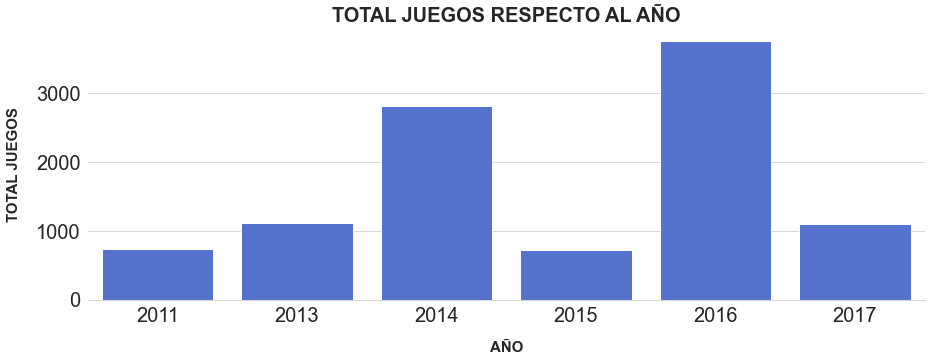

In [26]:
data = reviews.query('Usuario == "null"').loc[:,('Usuario', 'Cant. juegos', 'Fecha')].sort_values(by='Fecha',
                                                                                                  ascending=True)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data['Año'] = data['Fecha'].dt.year

data = data.groupby(by=['Año']).aggregate({ 'Cant. juegos': sum })

plt.figure(figsize=(15,5))
sns.barplot(x=data.index, y='Cant. juegos', data=data, color='Royalblue')
plt.title('Total juegos respecto al año'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Año'.upper(), fontsize=15, labelpad=15, weight='bold')
plt.ylabel('Total juegos'.upper(), fontsize=15, labelpad=15, weight='bold')
sns.despine(left=True)
plt.show()

Si tomamos *null* como el nombre de usuario podemos ver como el total de juegos varía año a año. Estos datos inducen al error ya que podemos observar como la cantidad de juegos que se adquirio debería ser constante de forma ascendente.

Este caso puede ser un usuario que eligió null como su nombre de usuario o hubo un inconveniente al momento de capturar el dato cuando se realizó el *web scrapping*.

In [12]:
idx = reviews.query('Usuario == "null"').index
reviews.drop(idx, inplace=True)

Respecto a estos casos, eliminamos los registros ya que es imposible identificar los usuarios a los que corresponden cada registro.

In [13]:
reviews['Usuario'] = reviews['Usuario'].astype('string')
reviews['Cant. horas'] = reviews['Cant. horas'].astype('float32')
reviews['Cant. juegos'] = reviews['Cant. juegos'].astype('float32')
reviews['Fecha'] = pd.to_datetime(reviews['Fecha'])
reviews['Comentario'] = reviews['Comentario'].astype('string')
reviews['Preview'] = reviews['Preview'].astype('category')
reviews['GameID'] = reviews['GameID'].astype('int32')
reviews.reset_index(drop=True, inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3634562 entries, 0 to 3634561
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Usuario       string        
 1   Cant. horas   float32       
 2   Cant. juegos  float32       
 3   Fecha         datetime64[ns]
 4   Comentario    string        
 5   Preview       category      
 6   GameID        int32         
dtypes: category(1), datetime64[ns](1), float32(2), int32(1), string(2)
memory usage: 128.2 MB


In [ ]:
#219441, 758210, 94304, 326670
#final_data.isna().sum()
#reviews_games[columns][reviews_games.Usuario.str.contains('[^\u0001-\u007F]{3,}')]
#username = reviews_games.Usuario.values
#username = reviews_games.Usuario.str.encode('utf-8')

###  Games

#### Duplicados

Empezamos con este análisis preliminar de duplicados buscando valores que se repitan a groso modo. Más adelante entraremos en un detalle realizando un análisis más profundo.

In [157]:
duplicados = len(games[games.drop(columns=['Especificaciones', 'Etiquetas','Géneros']).duplicated()])
print(f'Total de registros duplicados: { duplicados }')

Total de registros duplicados: 0


En está primer acercamiento, parece ser que no existen registros duplicados. Si analizamos las columnas que conforman dicho dataset nos encontramos que contamos con campos en los cuales difícilmente sean similares con otros registros. Por ejemplo, el atributo ```GameID``` es identificador único entre los distintos registros, a su vez, este mismo campo tiene influencia en el atributo ```Url``` ya que en la misma podemos encontrar dicho valor.

In [158]:
games.loc[1068, ['GameID', 'Aplicación', 'Url']]

GameID                                                   200260
Aplicación       Batman: Arkham City - Game of the Year Edition
Url           http://store.steampowered.com/app/200260/Batma...
Name: 1068, dtype: object

Como se puede verificar, en el campo *Url* se encuentra el GameID del juego. Si elegimos incorrectamente las columnas no vamos a encontrar registros duplicados. En este caso, se van a elegir los siguientes atributos: ```Aplicación```, ```Desarrollador```

In [184]:
games[games.loc[:,['Aplicación', 'Desarrollador']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
74,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,http://store.steampowered.com/,False,19.99,NaN,NaN
1068,200260,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)",2012-09-07,"[Action, Adventure]","[Single-player, Steam Achievements, Steam Trad...","[Action, Open World, Batman, Adventure, Stealt...",http://store.steampowered.com/app/200260/Batma...,False,19.99,Overwhelmingly Positive,91
1508,93304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Indie, Adventure, Casual, Great Soundtrack, S...",http://store.steampowered.com/app/93304/The_Dr...,False,4.99,NaN,NaN
1509,94304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Adventure, Indie, Casual]",http://store.steampowered.com/app/94304/The_Dr...,False,NaN,NaN,NaN
2580,317160,<NA>,<NA>,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive,NaN
4440,401200,Invisible Apartment 2,"Milan Kazarka,Jeroen van Oosten",2015-09-24,"[Adventure, Indie]",[Single-player],"[Adventure, Indie, Visual Novel, Anime, Hackin...",http://store.steampowered.com/app/401200/Invis...,False,7.99,4 user reviews,NaN
8117,529700,Total Extreme Wrestling,Grey Dog Software,2016-12-02,[Sports],[Single-player],"[Sports, Wrestling, Management]",http://store.steampowered.com/app/529700/Total...,False,19.99,Positive,NaN
10350,654070,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews,NaN
13155,773080,MORE SWEATER? OK!,Triple-Star Studio,2017-12-19,"[Casual, Indie, Simulation]","[Single-player, Downloadable Content, Steam Ac...","[Indie, Casual, Simulation]",http://store.steampowered.com/app/773080/MORE_...,False,0.99,NaN,NaN
13421,758210,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative,NaN


Como podemos visualizar, existen varios registros duplicados. En algunos de ellos se repite el atributo ```GameID```, en otros no pero varian los campos de otras columnas; también, nos encontramos con juegos donde la *fecha de lanzamiento* y el *nombre de la aplicación* del son equivalentes.

Sí nos basamos únicamente en el nombre vamos a encontrar muchos juegos con el mismo nombre pero distinto desarrollador. Sí buscamos juegos con el mismo nombre, el mismo desarrollador y la misma fecha de lanzamiento nos vamos a encontrar con algunos registros donde el nombre del desarrollador es distinto.

De acuerdo a la selección de columnas varían los duplicamos. Lo vemos a continuación:

In [160]:
print(f'Existen { len(games[games["Aplicación"].duplicated()]) } juegos duplicados por nombre.')
print(f'Existen { len(games[games[["Aplicación", "Desarrollador"]].duplicated()]) } juegos duplicados por nombre y desarrollador.')
print(f'Existen { len(games[games[["Aplicación", "Desarrollador", "Fecha lanzamiento"]].duplicated()]) } juegos duplicados por nombre, desarrollador y fecha.')

Existen 40 juegos duplicados por nombre.
Existen 9 juegos duplicados por nombre y desarrollador.
Existen 5 juegos duplicados por nombre, desarrollador y fecha.


Nos vamos a centrar en aquellos registros duplicados donde comparten el **nombre** y la **fecha de lanzamiento**.

In [161]:
games[games[['Aplicación', 'Fecha lanzamiento']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
1068,200260,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)",2012-09-07,"[Action, Adventure]","[Single-player, Steam Achievements, Steam Trad...","[Action, Open World, Batman, Adventure, Stealt...",http://store.steampowered.com/app/200260/Batma...,False,19.99,Overwhelmingly Positive,91
1508,93304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Indie, Adventure, Casual, Great Soundtrack, S...",http://store.steampowered.com/app/93304/The_Dr...,False,4.99,NaN,NaN
1509,94304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Adventure, Indie, Casual]",http://store.steampowered.com/app/94304/The_Dr...,False,NaN,NaN,NaN
10350,654070,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews,NaN
13421,758210,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative,NaN
13894,612880,Wolfenstein II: The New Colossus,Machine Games,2017-10-26,[Action],"[Single-player, Steam Achievements, Full contr...","[Action, FPS, Gore, Violent, Alternate History...",http://store.steampowered.com/app/612880/,False,59.99,Mostly Positive,86
14573,612880,Wolfenstein II: The New Colossus,Machine Games,2017-10-26,[Action],"[Single-player, Steam Achievements, Full contr...","[Action, FPS, Gore, Violent, Alternate History...",http://store.steampowered.com/app/612880/Wolfe...,False,59.99,Mostly Positive,86
27671,329270,Warhammer Quest,"Twistplay,Rodeo Games",2015-01-07,"[RPG, Strategy]","[Single-player, Downloadable Content, Steam Ac...","[Strategy, RPG]",http://store.steampowered.com/app/329270/Warha...,False,NaN,9 user reviews,55
27672,326670,Warhammer Quest,"Rodeo Games,Twistplay",2015-01-07,"[RPG, Strategy]","[Single-player, Steam Achievements, Steam Trad...","[RPG, Strategy, Games Workshop, Turn-Based, Bo...",http://store.steampowered.com/app/326670/Warha...,False,14.99,Mixed,55
30178,224850,Aliens: Colonial Marines - Reconnaissance Pack,Gearbox Software,2013-05-07,[Action],"[Single-player, Multi-player, Co-op, Downloada...",[Action],http://store.steampowered.com/app/224850/Alien...,False,NaN,NaN,NaN


Al ser pocos registros, se realizo una búsqueda por internet sobre los distintos registros y se encontró lo siguiente:

* **Aliens: Colonial Marines - Reconnaissance Pack**: Mismo artículo, url indica diferencia según país.
* **Batman: Arkham City - Game of the Year Edition**: Mismo artículo, solo uno tiene ```GameID```, se verifica en la url que es la misma en los dos registros.
* **Escape room**: Son dos juegos distintos.
* **The Dream Machine: Chapter 4**: El válido corresponde al siguiente ```GameID```: 94.304.
* **Warhammer Quest**: Uno corresponde a un juego y el otro a DLC (mismo árticulo, el campo desarrollador difiere).
* **Wolfenstein II: The New Colossus**: Difiere la ```Url``` pero corresponden al mismo juego.

Al ser pocos juegos duplicados sin posibilidad de filtrar el correcto se hace una eliminación manual. Los siguientes registros se eliminan: 30961, 30178, 13894, 1508.

In [14]:
games.drop([30961, 30178, 13894, 1508], axis=0, inplace=True)
games[games[['Aplicación', 'Fecha lanzamiento']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
10350,654070,Escape Room,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews
13421,758210,Escape Room,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative
27671,329270,Warhammer Quest,"Twistplay,Rodeo Games",2015-01-07,"[RPG, Strategy]","[Single-player, Downloadable Content, Steam Ac...","[Strategy, RPG]",http://store.steampowered.com/app/329270/Warha...,False,NaN,9 user reviews
27672,326670,Warhammer Quest,"Rodeo Games,Twistplay",2015-01-07,"[RPG, Strategy]","[Single-player, Steam Achievements, Steam Trad...","[RPG, Strategy, Games Workshop, Turn-Based, Bo...",http://store.steampowered.com/app/326670/Warha...,False,14.99,Mixed


A estos registros se los corrige para que sean acordes a la información que se extrae de la plataforma steam.

In [15]:
# Escape Room
games.loc[10350,'Desarrollador'] = 'AppFactoryHaru-Ni'
games.loc[10350,'Fecha lanzamiento'] = '2017-06-30'

games.loc[13421,'Desarrollador'] = 'OneTechAsia'
games.loc[13421,'Fecha lanzamiento'] = '2017-12-11'
# Warhammer Quest
games.loc[27671,'Desarrollador'] = 'Rodeo Games,Twistplay'

#### Valores faltantes

> **ACLARACIÓN**:
Descartamos del análisis las columnas ```Desarrollador```, ```Fecha lanzamiento```, ```Metascore```,  y ```Sentimiento``` ya que son las que destacan en valores nulos y no considero relevante su uso al momento de realizar el sistema de recomendación. Si las etiquetas ```Metascore```,  y ```Sentimiento``` tuviesen más datos sería un aporte sideral para la finalidad de nuestro proyecto. Recordemos que **Metascore tiene 29458 datos nulos (91.67%)** y **Sentimiento** tiene 7182 datos nulos (22.35%).

Analizamos los valores nulos de nuestro dataset correspondiente a los juegos. Nos vamos a enfocar en los siguientes atributos: ```GameID```, ```Aplicación```, ```Géneros```, ```Especificaciones```, ```Etiquetas```, ```Precio```.

In [131]:
games.isna().sum()

GameID                  1
Aplicación              2
Desarrollador        3297
Fecha lanzamiento    2065
Géneros              3283
Especificaciones      670
Etiquetas             163
Url                     0
Acceso previo           0
Precio               1376
Sentimiento          7180
dtype: int64

---
**GameID y Aplicación**

---
Buscamos los nulos de ```GameID``` y ```Aplicación``` ya que ellas mismas nos ayudan a entender que juego estamos analizando a través del nombre y del identificador.

In [165]:
games.query('Aplicación.isna() | GameID.isna()', engine='python')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
74,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,http://store.steampowered.com/,False,19.99,NaN,NaN
2580,317160,<NA>,<NA>,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive,NaN


Podemos corroborar que el registro 74 comparte nulidad en ```GameID``` y ```Aplicación```. Prodecemos a eliminarlo y vamos a tratar de completar los datos faltantes de los otros registros. 

In [16]:
games.drop([74], axis=0, inplace=True)
games.query('Aplicación.isna() | GameID.isna()', engine='python')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
2580,317160,NaN,NaN,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive


Buscamos a través del atributo ```Url``` información oficial *—plataforma de steam—* sobre el nombre del juego o el id. La url de cada registro nos brinda información importante como vimos anteriormente, nos ayuda a completar los datos faltantes y buscar información sobre el registro para entender con que se está lidiando.

In [11]:
print(games.loc[2580,:].Url)

http://store.steampowered.com/app/317160/_/


De esta url no podemos inferir el nombre del juego, ingresando en la misma si podemos corroborar esto. El juego en cuestión es un demo llamado **Duet**. Tratamos de inspeccionar en la base de datos información sobre este juego.

In [133]:
app_name = "Duet"
games.query('Aplicación == @app_name')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
4103,292600,Duet,Kumobius,2015-08-03,"[Action, Indie]","[Single-player, Steam Achievements, Full contr...","[Indie, Action, Minimalist, Great Soundtrack, ...",http://store.steampowered.com/app/292600/Duet/,False,4.99,Very Positive


Como se puede ver, corresponde a otro registro duplicado. Antes de eliminarlo deberiamos corroborar que el mismo no tenga ninguna review, también se debería realizar lo mismo con los registros que se eliminaron previamente. Al ser un demo de otro juego, podriamos eliminarlo y cambiar los registros en nuestro dataset referido a los comentarios para que estos apunten al juego final.

Eliminamos el demo del juego.

In [17]:
games.drop([2580], axis=0, inplace=True)

Correciones en el dataset ```Reviews```.

In [33]:
total = len(reviews.query('GameID == 317160')) + len(reviews.query('GameID == 224850')) + \
        len(reviews.query('GameID == 612880')) + len(reviews.query('GameID == 93304'))
print('Total de registros afectados: ' + str(total))

Total de registros afectados: 2998


El único registro que se ve afectado es el que corresponde al juego **Wolfenstein II: The New Colossus**, es un registro duplicado en el cuál solo difiere en la ```Url```, como se mencionó.

---
**Géneros, etiquetas y especificaciones**

---


El desafío con el que nos encontramos es completar la mayor cantidad de datos faltantes que en la variable categórica ```Géneros``` y ```Especificaciones```.

FUNCIÓN PARA GRÁFICAR LAS CATEGORÍAS

In [18]:
def get_data(category, data=games):
    data = data[category].dropna().to_numpy()
    unicos = []
    for items in data:
        if any(items):
            unicos.extend(items)
    values, count = np.unique(unicos, return_counts=True)
    return pd.DataFrame({ category: values, 'cantidad': count }), values

def graficar_categorias(filter):
    fig, axs = plt.subplots(1, 3, figsize=(20,8), tight_layout=True)
    fig.suptitle(f'Análisis de las categorias'.upper(), fontsize=25, fontweight='semibold')
    
    categories = ['Géneros', 'Especificaciones', 'Etiquetas']
    for idx, label in enumerate(categories):
        data = get_data(label)[0]
        data = data.pivot_table(values='cantidad', index=label,
                                aggfunc={ 'cantidad': lambda x: x*100/data['cantidad'].sum() })
        data = data.query(f'cantidad >= { filter }').reset_index()
        
        sns.barplot(x=label, y='cantidad', color='Royalblue', data=data, order=data.sort_values('cantidad', ascending=False)[label],
                    saturation=1, ax=axs[idx])
        axs[idx].set_title(f'{ label }'.upper(), fontsize=20, weight='bold')
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('Porcentaje'.upper(), fontsize=12, labelpad=10, weight='bold')
        axs[idx].tick_params(axis='both', labelsize=15)
        axs[idx].tick_params(axis='x', rotation=90)
    sns.despine(left=True)
    plt.show()

FUNCIÓN PARA COMPLETAR LOS VALORES FALTANTES

In [19]:
def completar(data, target_column):
    # Creamos una lista para guardar los tags para luego analizarlos.
    nulos = []
    index = data.index
    # Generamos una lista de valores únicos que posee la columna que deseamos completar.
    values = get_data('Géneros')[1] if target_column == 'Géneros' else get_data('Especificaciones')[1]
    # Generamos una lista de valores únicos que posee la otra columna.
    other = get_data('Géneros')[1] if target_column == 'Géneros' else get_data('Especificaciones')[1]
    for idx in index:
        # Buscamos los tags de cada registro.
        tags = games.at[idx, 'Etiquetas']
        if any(tags):
            # Calculamos la intersection con la columna a rellenar.
            intersection = set.intersection(set(tags), set(values))
            if any(intersection):
                # Guardamos los datos en el registro.
                games.at[idx, target_column] = list(intersection) 
            else:
                # Sino hay nada dejamos como null.
                games.at[idx, target_column] = np.nan
                # Guardamos los datos de tags que no pertenecen a la otra columna.
                nulos.extend(list(set(tags) - set(other)))
        else:
            print('Tags is null')
    return nulos

Antes de hacer un cualquier tarea, necesitamos hacer un análisis preliminar de los datos que contienen nuestras categorías.

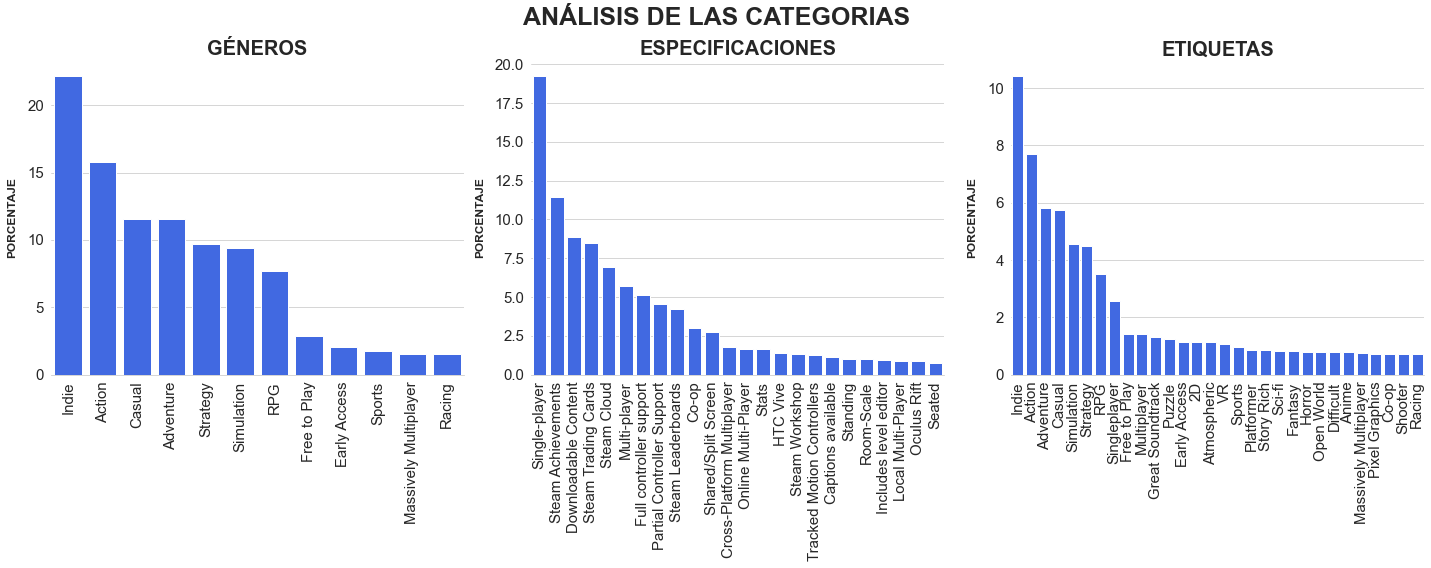

In [39]:
graficar_categorias(0.7)

El atributo ```Etiquetas``` merece un trato especial ya que contiene información que se encuentra en los otros dos atributos. En este caso, principalmente es importante conocer que información nueva puede aportarnos dicho atributo.

In [20]:
specs = get_data('Especificaciones')[1]
genres = get_data('Géneros')[1]
data, tags = get_data('Etiquetas')
tags = list(set(list(set(tags) - set(specs))) - set(genres))

total_cantidad = data['cantidad'].sum()
mask = data.isin(tags).loc[:,'Etiquetas']
data = data[mask].sort_values('cantidad', ascending=False)
data.head()

,Etiquetas,cantidad
261,Singleplayer,4343
183,Multiplayer,2383
128,Great Soundtrack,2233
223,Puzzle,2111
3,2D,1944


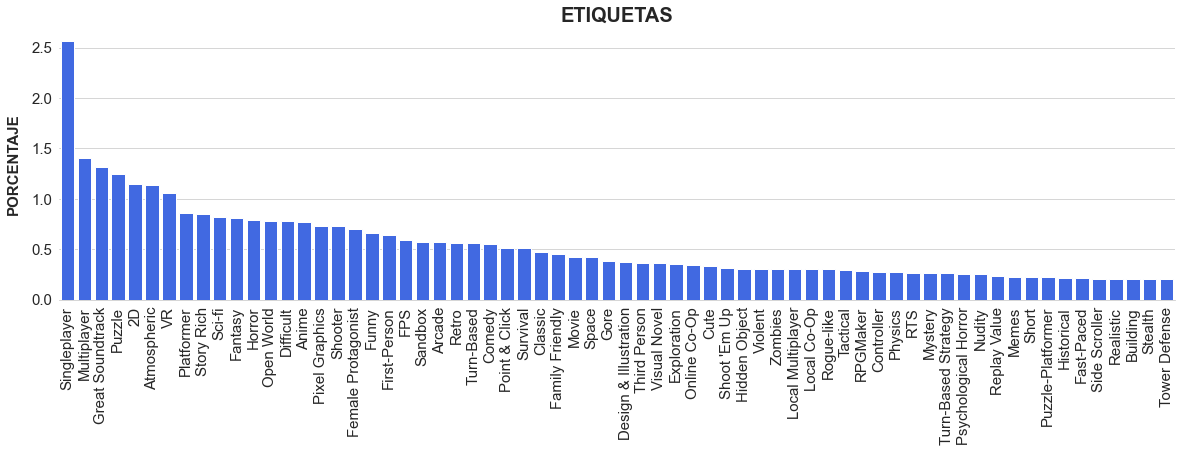

In [50]:
data = data.pivot_table(values='cantidad', index='Etiquetas',
                                aggfunc={ 'cantidad': lambda x: x*100/total_cantidad.sum() })
data = data.reset_index(drop=False)

plt.figure(figsize=(20,5))
sns.barplot(x='Etiquetas', y='cantidad', color='Royalblue', data=data.query('cantidad >= 0.20'),
            order=data.query('cantidad >= 0.20').sort_values('cantidad', ascending=False).Etiquetas,
            saturation=1)
plt.tick_params(axis='both', labelsize=15)
plt.tick_params(axis='x', rotation=90)
plt.title('Etiquetas'.upper(), fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('Porcentaje'.upper(), fontsize=15, labelpad=10, weight='bold')
sns.despine(left=True)
plt.show()

Podemos observar en la gráfica de datos perteneciente al atributo ```Etiquetas``` que en la misma contenemos datos que a apenas superan el 2.5% del total. Además, habiendo realizado un filtrado de valores únicos *—datos nuevos que aporta la categoría—* respecto a los otros atributos, encontramos que de nuestro top tres, solo el tercero es información nueva respecto a la que contenemos en los atributos ```Géneros``` y ```Especificaciones```. El mismo no logra superar el 1.5% del total.

*Esta categoría no aporta información nueva de forma significativa*, pero, si nos remitimos a nuestro análisis inicial de valores faltantes, nos encontramos que este atributo es el que menos datos faltantes posee. Por lo tanto, nos ayudaría a rellenar los valores faltantes que no tienen los otros atributos.


Evaluamos cuantos datos podemos completar en la categoría ```Géneros``` y ```Especificaciones```.

In [21]:
genres = games.query('Géneros.isna() & not Etiquetas.isna()', engine='python')
print(f'Existen { genres.shape[0] } registros a completar en la categoría GÉNEROS')
genres.head()

Existen 3144 registros a completar en la categoría GÉNEROS


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
4,773570,Log Challenge,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",http://store.steampowered.com/app/773570/Log_C...,False,2.99,NaN
11,724910,Icarus Six Sixty Six,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...",[Casual],http://store.steampowered.com/app/724910/Icaru...,False,Free,NaN
19,772590,After Life VR,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Indie, VR]",http://store.steampowered.com/app/772590/After...,True,4.99,NaN
20,640250,Kitty Hawk,NaN,NaN,NaN,"[Single-player, Steam Leaderboards, HTC Vive, ...","[Early Access, Action, Adventure, Indie, Casual]",http://store.steampowered.com/app/640250/Kitty...,True,2.99,NaN
22,711440,Mortars VR,NaN,NaN,NaN,"[Single-player, Multi-player, Online Multi-Pla...","[Early Access, Strategy, Action, Indie, Casual...",http://store.steampowered.com/app/711440/Morta...,True,0.99,8 user reviews


In [22]:
specs = games.query('Especificaciones.isna() & not Etiquetas.isna()', engine='python')
print(f'Existen { specs.shape[0] } registros a completar en la categoría ESPECIFICACIONES')
specs.head()

Existen 660 registros a completar en la categoría ESPECIFICACIONES


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
26,777910,Robotpencil Presents: Understanding 3D for Con...,NaN,2018-01-03,NaN,NaN,"[Design & Illustration, Tutorial]",http://store.steampowered.com/app/777910/Robot...,False,4.99,NaN
738,48220,Might & Magic: Heroes VI,Blackhole,2011-10-13,"[RPG, Strategy]",NaN,"[Strategy, RPG, Turn-Based Strategy, Turn-Base...",http://store.steampowered.com/app/48220/Might_...,False,19.99,Mixed
873,206760,Painkiller: Recurring Evil,Med-Art,2012-02-29,[Action],NaN,"[Action, FPS]",http://store.steampowered.com/app/206760/Paink...,False,9.99,Mixed
1793,257610,LogoMaker 4,Studio V5,2013-12-04,[Design &amp; Illustration],NaN,[Design & Illustration],http://store.steampowered.com/app/257610/LogoM...,False,29.99,Mixed
1828,262650,RaySupreme 3D,BrainDistrict,2013-12-16,[Animation &amp; Modeling],NaN,[Animation & Modeling],http://store.steampowered.com/app/262650/RaySu...,False,39.99,Mostly Negative


Realizamos las imputaciones de los datos faltantes y vemos cuáles quedaron fuera.

In [23]:
val_genres = completar(genres, 'Géneros')
val_specs = completar(specs, 'Especificaciones')

print('DATOS QUE NO SE TOMAN EN CUENTA LUEGO DE RELLENAR LOS VALORES FALTANTES')
val_genres = list(map(str.lower, np.unique(val_genres, return_counts=False)))
print('\nEtiquetas que quedaron afuera para géneros:\n', val_genres)
val_specs = list(map(str.lower, np.unique(val_specs, return_counts=False)))
print('\nEtiquetas que quedaron afuera para especificaciones:\n', val_specs)

DATOS QUE NO SE TOMAN EN CUENTA LUEGO DE RELLENAR LOS VALORES FALTANTES

Etiquetas que quedaron afuera para géneros:
 ['1980s', "1990's", '2d', '360 video', '3d platformer', '3d vision', 'action rpg', 'action-adventure', 'aliens', 'animation & modeling', 'anime', 'arcade', 'assassin', 'based on a novel', 'basketball', "beat 'em up", 'bullet hell', 'cartoon', 'character customization', 'chess', 'cinematic', 'classic', 'cold war', 'comedy', 'comic book', 'controller', 'crime', 'cute', 'cyberpunk', 'dark comedy', 'dark fantasy', 'dating sim', 'demons', 'design & illustration', 'detective', 'difficult', 'documentary', 'dragons', 'drama', 'episodic', 'fps', 'faith', 'family friendly', 'fantasy', 'female protagonist', 'football', 'foreign', 'funny', 'futuristic', 'game development', 'gaming', 'gore', 'great soundtrack', 'hack and slash', 'hacking', 'hardware', 'hidden object', 'historical', 'horror', 'illuminati', 'isometric', 'jrpg', 'kickstarter', 'local multiplayer', 'mmorpg', 'magic', 'm

Luego de haber aplicado correctamente las funciones que se crearon, podemos observar que existen valores faltantes en las columnas que planeabamos completar. Esto sucede ya que la información que proporciona la columna ```Etiquetas``` no pertenece a ninguna columna, es decir, son datos nuevos.

In [25]:
total = games.query('Especificaciones.isna() | Géneros.isna()', engine='python').shape[0]
print(f'Existen { total } registros donde no se pudieron realizar las imputaciones.')
games.query('Especificaciones.isna() | Géneros.isna()', engine='python').sample(10)

Existen 1379 registros donde no se pudieron realizar las imputaciones.


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
6618,275030,Punch! ViaCAD 2D/3D v9 + 3D Printing PowerPack LT,Evolution Software,2016-07-13,"[Animation &amp; Modeling, Design &amp; Illust...",NaN,"[Design & Illustration, Animation & Modeling]",http://store.steampowered.com/app/275030/Punch...,False,99.99,9 user reviews,NaN
18142,609500,Comedy Dynamics: Coming to The Stage,<NA>,2015-05-06,NaN,[Captions available],[Episodic],http://store.steampowered.com/app/609500/Comed...,False,29.99,NaN,NaN
15016,726400,Aliens: Zone-X,<NA>,2016-08-25,NaN,[Captions available],[Movie],http://store.steampowered.com/app/726400/Alien...,False,4.99,NaN,NaN
17050,668180,Ghost Ship,<NA>,NaN,NaN,"[HTC Vive, Oculus Rift, Tracked Motion Control...","[360 Video, Short]",http://store.steampowered.com/app/668180/Ghost...,False,Free,3 user reviews,NaN
14586,734190,GAMERS!,<NA>,2017-10-26,NaN,NaN,"[Episodic, Anime]",http://store.steampowered.com/app/734190/GAMERS/,False,1.99,4 user reviews,NaN
18505,615720,Jimmy Dore: Sentenced to Live,<NA>,2011-09-26,NaN,[Captions available],[Movie],http://store.steampowered.com/app/615720/Jimmy...,False,3.99,1 user reviews,NaN
11899,728520,Still Breathing,<NA>,1998-05-01,NaN,[Captions available],[Movie],http://store.steampowered.com/app/728520/Still...,False,4.99,NaN,NaN
23413,421440,Rounders,<NA>,1999-02-09,NaN,[Captions available],"[Movie, Drama, Crime]",http://store.steampowered.com/app/421440/Round...,False,3.99,NaN,NaN
23073,459480,Leap of Fate - Soundtrack,Vibe Avenue,2016-05-20,NaN,[Downloadable Content],NaN,http://store.steampowered.com/app/459480/Leap_...,False,3.99,1 user reviews,NaN
8877,597800,Eugene Mirman: Vegan On His Way To The Complai...,<NA>,2015-07-01,NaN,[Captions available],[Movie],http://store.steampowered.com/app/597800/Eugen...,False,3.99,NaN,NaN


Verificamos los valores nulos que no pueden ser completados ya que, la columna ```Género``` posee datos faltantes, la columna ```Especificaciones``` posee datos faltantes y la columna ```Etiquetas``` también posee datos faltantes.

In [26]:
total = games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python').shape[0]
print(f'Existen { total } registros donde las tres columnas son nulas.')
games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python')

Existen 7 registros donde las tres columnas son nulas.


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
5373,382990,BrainBread 2 Mod Tools,<NA>,2016-02-17,NaN,NaN,NaN,http://store.steampowered.com/app/382990/Brain...,False,NaN,NaN,NaN
9560,582400,Alien Swarm: Reactive Drop Dedicated Server,<NA>,2017-04-20,NaN,NaN,NaN,http://store.steampowered.com/app/582400/Alien...,False,NaN,NaN,NaN
21335,531340,Steam Controller Skin - CSGO Blue/Orange,<NA>,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531340/Steam...,False,9.99,NaN,NaN
21336,531360,Steam Controller Skin - CSGO Grey Camo,<NA>,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531360/Steam...,False,9.99,NaN,NaN
21337,531430,Steam Link Skin - CSGO Blue/Orange,<NA>,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531430/Steam...,False,9.99,NaN,NaN
23326,451330,IS Defense Editor,<NA>,2016-04-29,NaN,NaN,NaN,http://store.steampowered.com/app/451330/IS_De...,False,NaN,6 user reviews,NaN
27738,338440,BOMB Dedicated Server,<NA>,2014-12-17,NaN,NaN,NaN,http://store.steampowered.com/app/338440/BOMB_...,False,NaN,NaN,NaN


Inicialmente, eliminamos estos registros y luego procedemos a eliminar aquellos valores nulos de las listas luego de haber creado una única variable que agrupe los datos de las tres categorías.

In [24]:
idx = games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python').index
games.drop(idx, inplace=True)

Llenamos los valores nulos de nuestras categorías con listas vacias y formateamos las cadenas de caracteres de nuestros atributos categóricos con la finalidad de eliminar apóstrofes, mayúsculas, guiones medios, etc.

In [25]:
for column in ['Géneros', 'Especificaciones', 'Etiquetas']:
    games[column].fillna({ i: [] for i in games.index }, inplace=True)
    games[column] = games[column].map(lambda x: [ re.sub(r'[^\w\s]', '', item).lower() for item in x])

---
**PRECIO**

---

Por útlimo, analizamos el atributo precio.

In [26]:
precios = np.array([i for i in list(games.Precio) if (type(i) == str)])
np.unique(precios)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free Movie', 'Free To Play', 'Free to Play', 'Free to Try',
       'Free to Use', 'Install Now', 'Install Theme', 'Play Now',
       'Play WARMACHINE: Tactics Demo', 'Play for Free!', 'Play the Demo',
       'Starting at $449.00', 'Starting at $499.00', 'Third-party'],
      dtype='<U29')

Transformamos los precios en una variable categórica para identificar cuáles son pagos y cuales gratuitos.

In [27]:
games['Precio'] = games.Precio.apply(lambda p: 'Pago' if (type(p) == float or p.startswith('Starting')) else 'Gratis')
games['Precio'] = games['Precio'].astype('category')
games.head()

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
0,761140,Lost Summoner Kitty,Kotoshiro,2018-01-04,"[action, casual, indie, simulation, strategy]",[singleplayer],"[strategy, action, indie, casual, simulation]",http://store.steampowered.com/app/761140/Lost_...,False,Pago,NaN
1,643980,Ironbound,Secret Level SRL,2018-01-04,"[free to play, indie, rpg, strategy]","[singleplayer, multiplayer, online multiplayer...","[free to play, strategy, indie, rpg, card game...",http://store.steampowered.com/app/643980/Ironb...,False,Gratis,Mostly Positive
2,670290,Real Pool 3D - Poolians,Poolians.com,2017-07-24,"[casual, free to play, indie, simulation, sports]","[singleplayer, multiplayer, online multiplayer...","[free to play, simulation, sports, casual, ind...",http://store.steampowered.com/app/670290/Real_...,False,Gratis,Mostly Positive
3,767400,弹炸人2222,彼岸领域,2017-12-07,"[action, adventure, casual]",[singleplayer],"[action, adventure, casual]",http://store.steampowered.com/app/767400/2222/,False,Pago,NaN
4,773570,Log Challenge,NaN,NaN,"[sports, action, indie, casual]","[singleplayer, full controller support, htc vi...","[action, indie, casual, sports]",http://store.steampowered.com/app/773570/Log_C...,False,Pago,NaN


Transformamos los precios en una variable categórica para identificar cuáles son pagos y cuáles gratuitos.

In [33]:
games.isna().sum()

GameID                  0
Aplicación              0
Desarrollador        3295
Fecha lanzamiento    2064
Géneros                 0
Especificaciones        0
Etiquetas               0
Url                     0
Acceso previo           0
Precio                  0
Sentimiento          7179
dtype: int64

#### Análisis de variables categóricas

Analizamos las variables categóricas con el fín de pulir los datos y que los mismos tengan consistencia. De aquí, se puede observar que los atributos que destacan son: ```Géneros```, ```Etiquetas```, ```Especificaciones```, ```Precio``` y ```Acceso previo```.

---
**Géneros, etiquetas y especificaciones**

---
En estos tres atributos, los registros contienen listas en sus campos; necesitamos crear una columna única que extraiga las carácteristicas de cada registro.

In [28]:
games['Categorías'] = games['Especificaciones'] + games['Etiquetas'] + games['Géneros']
games['Categorías'] = [np.unique(category) for category in games.Categorías]

In [59]:
np.unique(list(itertools.chain(*games['Categorías'])))

array(['1980s', '1990s', '25d', '2d', '2d fighter', '360 video',
       '3d platformer', '3d vision', '4 player local', '4x', '6dof',
       'abstract', 'accounting', 'action', 'action rpg',
       'actionadventure', 'adventure', 'agriculture', 'aliens',
       'alternate history', 'america', 'animation  modeling',
       'animation amp modeling', 'anime', 'arcade', 'arena shooter',
       'artificial intelligence', 'assassin', 'asynchronous multiplayer',
       'atmospheric', 'audio production', 'base building',
       'based on a novel', 'basketball', 'batman', 'beat em up',
       'benchmark', 'bikes', 'blood', 'board game', 'bowling', 'building',
       'bullet hell', 'bullet time', 'capitalism', 'captions available',
       'card game', 'cartoon', 'cartoony', 'casual',
       'character action game', 'character customization', 'chess',
       'choices matter', 'choose your own adventure', 'cinematic',
       'city builder', 'classbased', 'classic', 'clicker', 'cold war',
       'c

Estos son las características únicas que poseen cada videojuegos. Llegado a este punto se puede realizar un filtrado eliminando buscando videojuegos, aplicaciones de edición, etc.

Eliminamos las columnas `Desarrollador`, `Especificaciones`, `Etiquetas`, `Fecha lanzamiento`, `Géneros`, `Sentimiento` y `Url` ya que cumplieron con su propósito en está etapa.

In [29]:
games.drop(columns=['Desarrollador', 'Especificaciones', 'Etiquetas', 'Fecha lanzamiento', 'Géneros', 'Sentimiento', 
                    'Url'], inplace=True)
games.sample(5)

,GameID,Aplicación,Acceso previo,Precio,Categorías
17834,616640,B-12: Brantisky Mk. 12,True,Pago,"[3d platformer, action, arcade, difficult, ear..."
17200,617550,Prism,False,Pago,"[utilities, video production]"
15809,695000,Fantasy Grounds - D&D Tomb of Annihilation,False,Pago,"[coop, crossplatform multiplayer, downloadable..."
20270,560670,Fantasy Grounds - Daring Tales of Chivalry #02...,False,Pago,"[coop, crossplatform multiplayer, downloadable..."
8834,574672,VRC PRO Americas On-road tracks Deluxe,False,Pago,"[action, casual, downloadable content, indie, ..."


In [30]:
games.reset_index(drop=True, inplace=True)
games['GameID'] = games['GameID'].astype('uint32')
games['Aplicación'] = games['Aplicación'].astype('string')
games['Acceso previo'] = games['Acceso previo'].astype('category')
games['Precio'] = games['Precio'].astype('category')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32122 entries, 0 to 32121
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GameID         32122 non-null  uint32  
 1   Aplicación     32122 non-null  string  
 2   Acceso previo  32122 non-null  category
 3   Precio         32122 non-null  category
 4   Categorías     32122 non-null  object  
dtypes: category(2), object(1), string(1), uint32(1)
memory usage: 690.5+ KB


## **Análisis de Datasets**

En esta sección se pretende analizar los dataset para entender los mismos y extraer información que nos puede ayudar a generar un mejor *sistema de recomendación*.

### Merge

Hacemos el unificado de los datasets a través de la columna ```GameID```, que poseen en común.

In [31]:
reviews_games = reviews.merge(games, how='left', left_on='GameID', right_on='GameID',
                              suffixes=('REVIEWS_', 'GAMES_'))
reviews_games.head()

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID,Aplicación,Acceso previo,Precio,Categorías
0,No Man's Sky,3.000000,10.0,2018-01-05,finaly a game that has everything to do about ...,False,504370,Battlerite,False,Gratis,"[action, arena shooter, atmospheric, beat em u..."
1,Ori,26.900000,47.0,2018-01-05,Buy it play it love it,False,447530,VA-11 Hall-A: Cyberpunk Bartender Action,False,Pago,"[adventure, anime, atmospheric, casual, choice..."
2,mhputnam27,261.299988,6.0,2018-01-05,Spelunky is my favorite game. I feel like a lo...,False,239350,Spelunky,False,Pago,"[2d, action, adventure, controller, coop, diff..."
3,Pink Panther,3.300000,41.0,2018-01-05,Terrorist !,False,239350,Spelunky,False,Pago,"[2d, action, adventure, controller, coop, diff..."
4,⚡ SCARLETT SPEEDSTER ⚡,259.000000,1.0,2018-01-05,Ok SO IF YOU WANT HACKERS IN EVERY MATCH THEN ...,False,730,Counter-Strike: Global Offensive,False,Pago,"[action, competitive, coop, difficult, esports..."


Verificamos que los registros correspondientes a los comentarios de los usuarios estén haciendo referencia a un producto que tengamos en nuestro dataset de videojuegos.

In [56]:
reviews_games.isna().sum()

Usuario          0
Cant. horas      0
Cant. juegos     0
Fecha            0
Comentario       0
Preview          0
GameID           0
Aplicación       0
Acceso previo    0
Precio           0
Categorías       0
dtype: int64

### Visualizaciones

Gráficamos tratando de encontrar algunas respuestas en nuestros datos con la finalidad de tener una mayor comprensión de los mismos.

---
**TOP 10: Usuario con más comentarios**

---

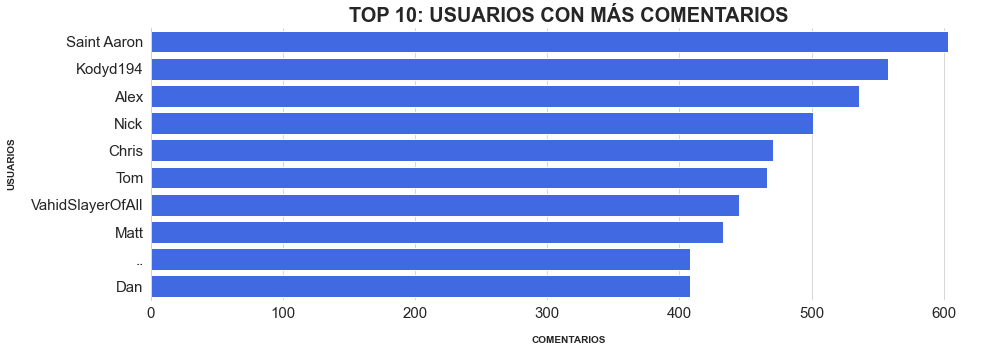

In [49]:
data = reviews_games.groupby('Usuario').agg(Comentarios=pd.NamedAgg(column='Comentario', aggfunc='count')).sort_values('Comentarios',
                                                                                                                       ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,5))
sns.barplot(x='Comentarios', y='Usuario', data=data, color='Royalblue', saturation=1)
plt.title('TOP 10: Usuarios con más comentarios'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

---
**TOP 10: Juegos con más comentarios**

---

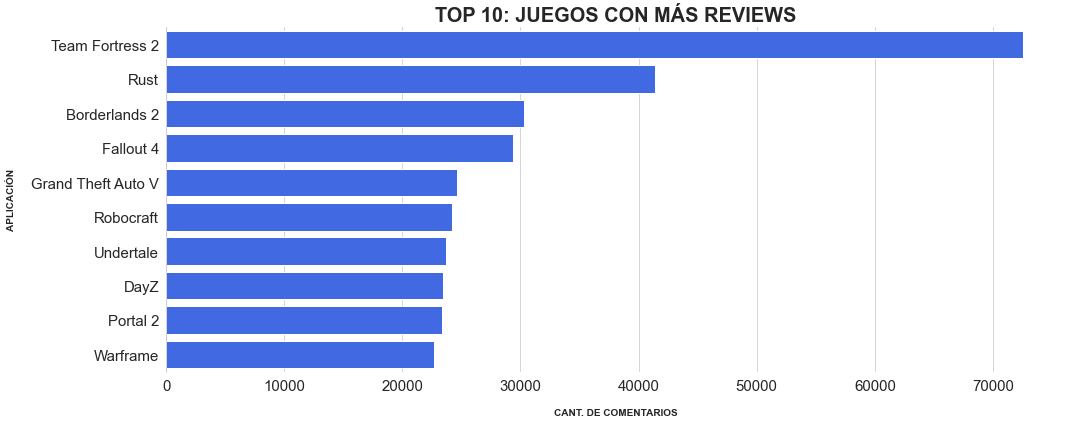

In [36]:
data = reviews_games.groupby('Aplicación').agg(Comentarios=pd.NamedAgg(column='Comentario', aggfunc='count'))\
                                          .sort_values('Comentarios', ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,5), tight_layout=True)
sns.barplot(x='Comentarios', y='Aplicación', data=data, color='Royalblue', saturation=1)
plt.title('Top 10: Juegos con más reviews'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Cant. de comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

Con los datos que contamos es posible analizar que sucede con el acceso anticipado de los diferentes productos.

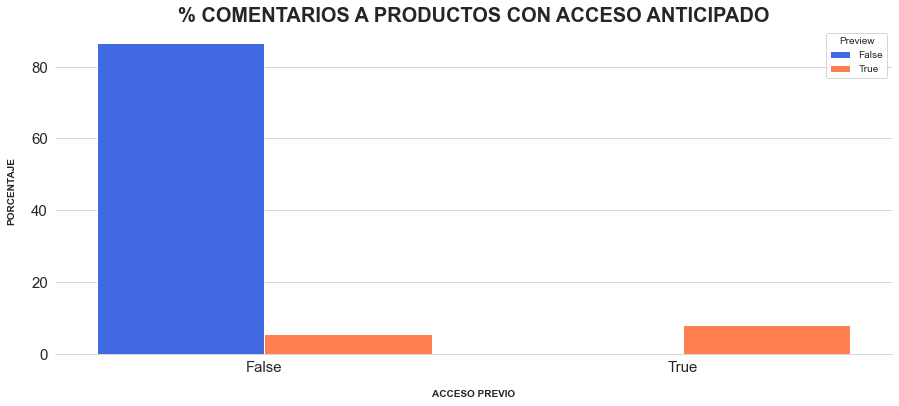

In [37]:
data = reviews_games.groupby(['Acceso previo', 'Preview']).agg(Usuarios=pd.NamedAgg(column='Usuario',
                                                                                   aggfunc=lambda x:len(x)/len(reviews_games)*100))
data.reset_index(inplace=True)

font = { 'weight':'bold', 'size':'15' }
plt.figure(figsize=(15,5))
sns.barplot(x='Acceso previo', y='Usuarios', data=data, palette=['Royalblue', 'Coral'], hue='Preview', saturation=1)
plt.title('% comentarios a productos con acceso anticipado'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Acceso previo'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

Este gráfico a simple vista desconcierta bastante. Antes de entender que sucede, vamos a entender como funciona la estrategia del acceso anticipado: 

> El acceso anticipado o acceso temprano (en inglés, early access) es un modelo de financiación en la industria de los videojuegos por el cual los consumidores pueden pagar por un videojuego en los diversos ciclos de desarrollo (pre alfa, alfa, beta) y obtener acceso a las versiones previas al lanzamiento oficial, mientras que el desarrollador puede usar esos fondos para continuar trabajando en el desarrollo del videojuego.

En este caso, hay usuarios que realizan comentarios sobre productos cuando este se encuentra en etapas tempranas de desarrollo, pero otros, hacen comentarios sobre esos mismos producto cuando este tiene una versión final del mismo. De ahí esas diferencias en los gráficos.

Cuando un producto utilizó la estrategia de acceso anticipado, este capturó a casi el 10% de los usuarios presentes en nuestro dataset.

In [38]:
games_tt = reviews_games.query('`Acceso previo` == True & Preview == True').GameID
games_ft = reviews_games.query('`Acceso previo` == False & Preview == True').GameID

idx_games = games_tt.append(games_ft)
print(f'{ len(idx_games.unique()) } productos tuvieron comentarios en distintas etapas de desarrollo por los usuarios.')

2240 productos tuvieron comentarios en distintas etapas de desarrollo por los usuarios.


Analizamos uno de esos juegos para poder ilustrar lo que se explicó.

In [42]:
cols = ['Usuario', 'Fecha', 'Comentario', 'Preview', 'GameID', 'Aplicación', 'Acceso previo']
reviews_games.loc[:,cols].query('GameID == 346110 & (Preview == True | Preview == False)').sample(2)

,Usuario,Fecha,Comentario,Preview,GameID,Aplicación,Acceso previo
1002602,MHEheeheehee,2017-03-04,I really wanted this game because it has dinos...,True,346110,ARK: Survival Evolved,False
492372,A.D.A.M,2017-09-04,This game is not worth $60 it needs to go back...,False,346110,ARK: Survival Evolved,False


Como se observa, el producto **ARK: Survival Evolved** es un juego que ya no se encuentra en etapas de acceso anticipado pero, inicialmente si lo estuvo. De los comentarios que podemos observar, el más antiguo delata esta situación.

Debido a esta inconsistencia en los datos, hacemos las modificaciones necesarias en nuestros datos y volvemos a realizar un merge. Solo queremos corregir aquellos juegos que, en algún momento, tuvieron acceso previo.

In [43]:
idx = games.query('GameID in @idx_games.unique()').index
games.loc[idx,'Acceso previo'] = True

reviews_games = reviews.merge(games, how='left', left_on='GameID', right_on='GameID',
                              suffixes=('REVIEWS_', 'GAMES_'))
reviews_games.sample(5)

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID,Aplicación,Acceso previo,Precio,Categorías
15868,Gandulf,1421.900024,51.0,2018-01-02,very fun and it isn't really addicting because...,False,730,Counter-Strike: Global Offensive,False,Pago,"[action, competitive, coop, difficult, esports..."
591223,[Ebola]Knastymike,0.200000,78.0,2017-07-30,The idea behind this game got me to buy it. W...,False,365020,Gynophobia,True,Pago,"[action, adventure, atmospheric, dark, experim..."
2405126,Chozo55,1.000000,203.0,2015-08-14,This game is actually pretty fun. It has a goo...,False,375930,Trap Them,False,Pago,"[2d, action, adventure, arcade, casual, contro..."
988636,CaptKelso,458.899994,84.0,2017-03-11,"Love Dirty Bomb, play it way too often. It's ...",False,333930,Dirty Bomb®,False,Gratis,"[action, classbased, competitive, controller, ..."
1363692,Marleone,1291.300049,131.0,2016-11-23,Not bad Pros: - Army at your command - Nice pr...,False,48700,Mount & Blade: Warband,False,Pago,"[action, adventure, fantasy, firstperson, hack..."


Corroboramos nuevamente nuestros datos y vemos que resulta.

In [300]:
usuarios = reviews_games.groupby(['Acceso previo', 'Preview']).agg(Porcentaje=pd.NamedAgg(column='Usuario',
                                                                                          aggfunc=lambda x:len(x)/len(reviews_games)*100))
usuarios.fillna(0, inplace=True)
productos = games.groupby('Acceso previo').agg(Porcentaje=pd.NamedAgg(column='GameID', aggfunc=lambda x: len(x)/len(games)*100))

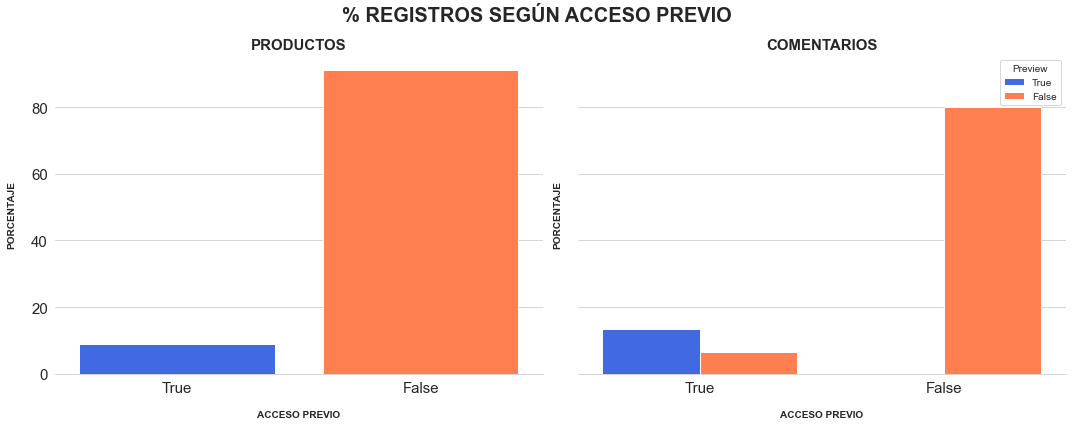

In [343]:
data = [ productos, usuarios ]

fig, axs = plt.subplots(1, 2, figsize=(15,6), tight_layout=True, sharey=True)
fig.suptitle('% registros según acceso previo'.upper(), fontsize=20, fontweight='bold')
for x in range(0,2):
    plot = data[x]
    hue = 'Preview' if x > 0 else None
    sns.barplot(x='Acceso previo', y='Porcentaje', data=plot.reset_index(), palette=['Royalblue', 'Coral'], hue=hue,
                hue_order=[True, False],
                order=[True, False], saturation=1, ax=axs[x])
    axs[x].set_title(f'{ "Productos" if x == 0 else "Comentarios" }'.upper(), fontsize=15, fontweight='bold')
    axs[x].set_xlabel('Acceso previo'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
sns.despine(left=True)
plt.show()

Como se puede observar, ya no existen artículos sin acceso previo con comentarios que si eran de dicha instancia del producto. Escasamente, los productos que implementaron dicha estrategia llegan al 10% de nuestros datos, por otro parte, si bien existe mayor proporción de datos a productos sin acceso previo, los que comentarios que pertenecen a los artículos que sí lo implementaron llegan al 20%. Esto es un primer indicio de la importancia de dicha estrategia para con los usuarios.

Vamos a adentrarnos en el análisis de esta porción de nuestros datos, productos que permitieron a los usuarios acceder a etapas previas del desarrollo; inicialmente, identificamos los ***usuarios que tuvieron acceso anticipado a los diferentes productos***.

In [441]:
mask = reviews_games['Acceso previo'] == True
idx = reviews_games[mask].GameID.unique()
data = reviews_games.query('GameID in @idx')

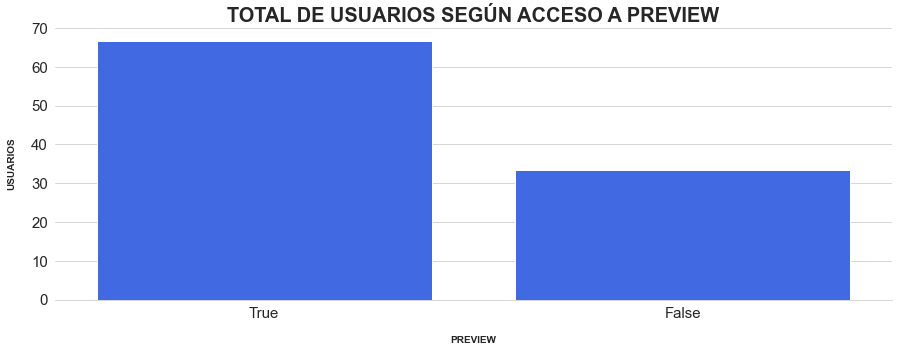

In [397]:
plot = data.pivot_table(index='Preview', values='Usuario', aggfunc=lambda x: len(x.unique()))
plot['Usuario'] = plot['Usuario']/plot['Usuario'].sum()*100
plot = plot.reset_index()

plt.figure(figsize=(15,5))
sns.barplot(x='Preview', y='Usuario', data=plot, color='Royalblue', order=plot.sort_values('Usuario', ascending=False).Preview,
            saturation=1)
plt.title('Total de usuarios según acceso a preview'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Preview'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

Como se observa, aproximadamente el doble de usuarios decidieron ingresar al acceso anticipado de los productos. Continuamos analizando esta porción de nuestros datos, productos que si implementaron el acceso previo para los usuarios, identificamos el ***total de productos que son pagos versus aquellos que son gratuitos***.

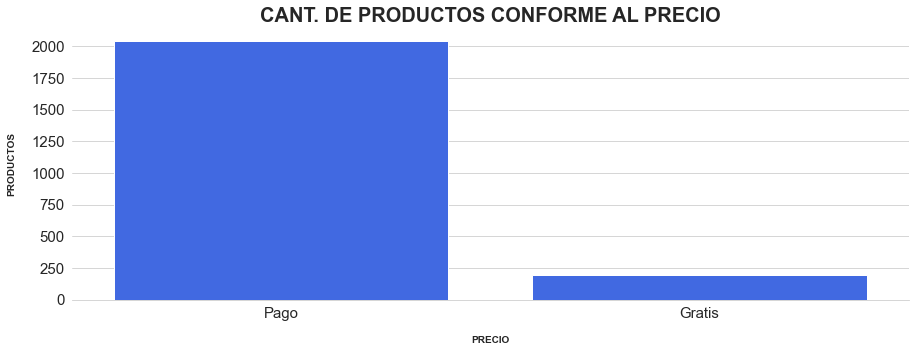

In [398]:
plot = data.pivot_table(index='Precio', values='GameID', aggfunc=lambda x: len(x.unique()))

plt.figure(figsize=(15,5))
sns.barplot(x=plot.index, y='GameID', data=plot, color='Royalblue', order=['Pago', 'Gratis'], saturation=1)
plt.title('Cant. de productos conforme al precio'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Productos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

En estas últimas dos gráficas vimos la cantidad de usuarios que decidieron ingresar en las etapas previas del desarrollo de los productos, como vimos, más del 65% optó por esta modalidad. A su vez, dicha estrategia es utilizada mayoritariamente por productos pagos, lo que nos da una pauta que estos aprovechan el feedback de los usuarios para realizar mejoras en la aplicación con el objetivo de llegar a un mayor público una vez que el mismo tiene una versión estable final.

Si juntamos estas dos gráficas en una obtenemos lo siguiente:

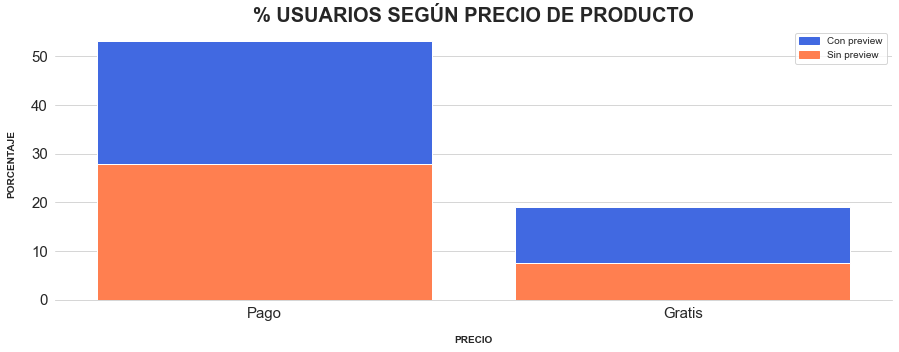

In [399]:
total = data.pivot_table(index='Precio', values='Usuario', aggfunc=lambda x: len(x.unique())).sum()
plot = data.pivot_table(index='Precio', columns='Preview', values='Usuario', aggfunc=lambda x: len(x.unique()))
plot = plot.unstack().reset_index()
plot.rename(columns={ 0: 'Total usuarios' }, inplace=True)
plot['Total usuarios'] = plot['Total usuarios']/total.values*100

plt.figure(figsize=(15,5))
preview = plot.query('Preview == True')
sns.barplot(x='Precio', y='Total usuarios', data=preview, color='Royalblue', order=['Pago', 'Gratis'],
            saturation=1)
preview = plot.query('Preview == False')
sns.barplot(x='Precio', y='Total usuarios', data=preview, color='Coral', order=['Pago', 'Gratis'], saturation=1)
top = mpatches.Patch(color='Royalblue', label='Con preview')
bottom = mpatches.Patch(color='Coral', label='Sin preview')
plt.title('% Usuarios según precio de producto'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.legend(handles=[top, bottom], fontsize=10)
sns.despine(left=True)
plt.show()

Observamos como la mayoría de usuarios tuvieron acceso anticipado a diferentes artículos, sin importar que el mismo fuese pago o no. Cada vez queda más claro la efectividad de dicha estrategia.

Continuamos desmenuzando nuestros datos, observamos las distribuciones de los usuarios según el acceso previo de los productos, siempre mirando aquellos productos que si implementaron dicha estrategia. Estamos tratando de entender que sucede con esos artículos y porque los usuarios se decantan, o no, por participar en versiones previas de desarrollo.

In [400]:
plot = data.pivot_table(index='GameID', columns='Preview', values='Usuario', margins=True,
                        aggfunc='count').rename(columns={ 'All' : 'Totales' })
plot.describe()

Preview,False,True,Totales
count,2241.000000,2241.000000,2241.000000
mean,208.127622,437.380634,645.508255
std,4949.949262,10442.945563,15358.664941
min,0.000000,1.000000,1.000000
25%,0.000000,4.000000,6.000000
50%,0.000000,13.000000,21.000000
75%,17.000000,57.000000,106.000000
max,233207.000000,490085.000000,723292.000000


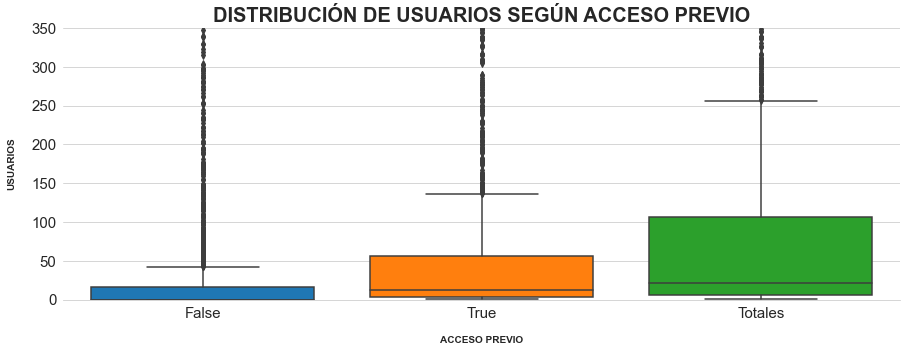

In [401]:
plt.figure(figsize=(15,5))
sns.boxplot(data=plot, saturation=1)
plt.title('Distribución de usuarios según acceso previo'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Acceso previo'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylim(0,350)
sns.despine(left=True)
plt.show()

En la siguiente gráfica visualizamos los ***diez productos que acapararon a la mayor cantidad de usuarios y los diez productos que peor les fue con esta estrategia***. La idea de esta gráfica no es conocer los productos que no tuvieron tantos adeptos a opinar sobre el mismo.

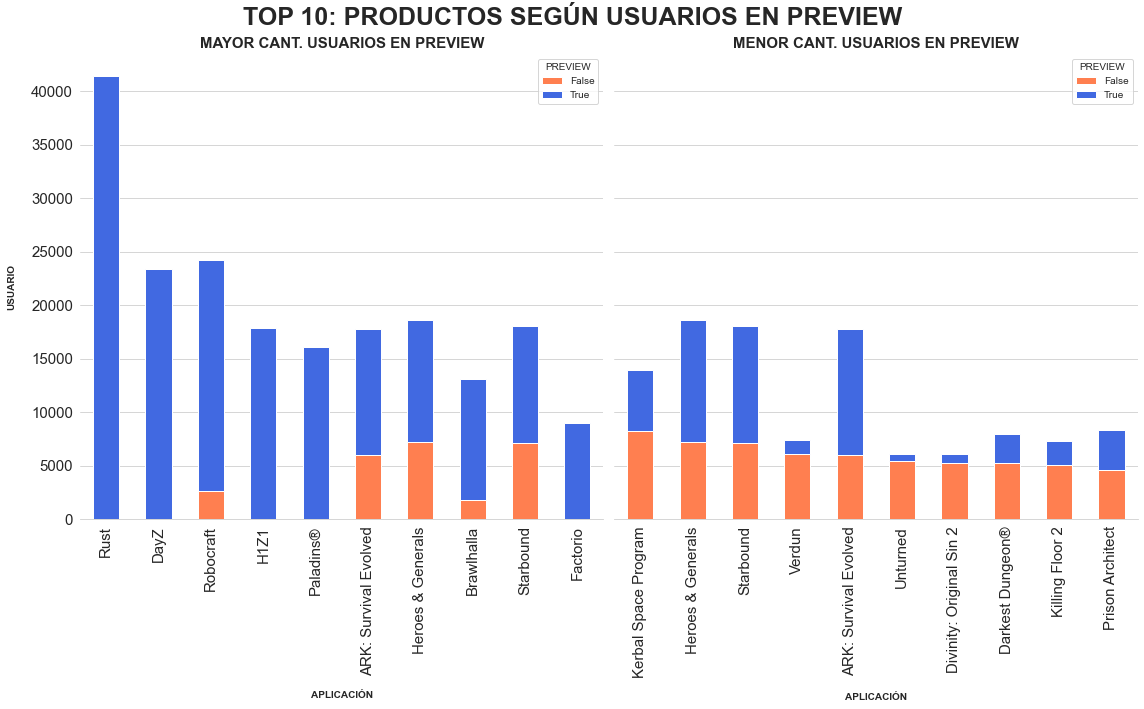

In [402]:
plot = plot.merge(games.loc[:,['GameID', 'Aplicación']], how='inner', left_on='GameID', right_on='GameID')
columns = [True, False]

fig, axs = plt.subplots(1, 2, figsize=(16,10), tight_layout=True, sharey=True)
for x in range(0,2):
    var = columns[x]
    plot.sort_values(by=var, ascending=False, inplace=True)
    plot.head(10).drop(columns=['GameID', 'Totales']).plot(ax=axs[x], color=['Coral', 'Royalblue'], kind='bar',
                                                           stacked=True, x='Aplicación', xlabel='')
    axs[x].legend(title='Preview'.upper())
    subtitle = f'{ "Mayor" if var == True else "Menor" } cant. usuarios en preview'.upper()
    axs[x].set_title(subtitle, fontsize=15, fontweight='bold')
    axs[x].set_xlabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Usuario'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
    axs[x].grid(axis='x')
fig.suptitle('Top 10: Productos según usuarios en preview'.upper(), fontsize=25, fontweight='bold')
sns.despine(left=True)
plt.show()

Como podemos observar, hay productos que lograron que el 100% de los usuarios que accedieron al avance del mismo, realizaron un comentario sobre el producto *—vale hacer algunas aclaraciones, nuestros datos de origen cuenta con 7.793.069 de comentarios y por razones de procesamiento, solo se utilizó la mitad—*. Esto demuestra el nivel de espectativa y emoción que tenían los usuarios por dichos productos junto a las ganas de compartir su experiencia en las etapas iniciales del producto.

De lo analizado hasta el momento, no encontramos ningún análisis que nos pueda indicar que sucede en la interacción usuario-producto. Solo nos hemos limitado a comprender que sucede por encima, rascamos la superficie de nuestro universo *—recordemos que centramos el análisis en aquellos productos que implementaron en el pasado o bien, en el período de recolección de nuestros datos, el acceso previo para los usuarios, `reviews_games['Acceso previo'] == True`—*, hicimos algunas segmentación, detectamos poblaciones pero no entramos en el comportamiento de los usuarios utilizando dichos productos. Aquí encontramos el atributo `Cant. horas`, el cuál nos indica el tiempo que un usuario pasa utilizando el producto al momento de realizar un comentario.

Orientamos nuestro análisis para poner énfasis en ese objetivo.

In [403]:
data.loc[:,['Cant. horas', 'Cant. juegos']].describe()

,Cant. horas,Cant. juegos
count,723292.000000,723292.000000
mean,119.415596,181.506485
std,338.254272,392.262421
min,0.000000,1.000000
25%,4.800000,36.000000
50%,21.100000,86.000000
75%,86.800003,193.000000
max,18549.800781,12832.000000


En nuestros resumen de datos estadísticos encontramos que existe una gran dispersión en los datos, se puede observar que la desviación estandar es de casi 400 productos y de 14 días respecto a la cantidad de horas. 

Analizando el atributo `Cant. de productos` me encuentro con lo siguiente: dicho atributo lo tomé como las transacciones que tiene hechas el usuario *—si se hizo una compra/instalación de x cantidad de artículos de la tienda—* al momento de realizar un comentario.

In [476]:
user = 'Ori'
data.query('Usuario == @user').loc[:,['Usuario', 'Cant. juegos', 'Fecha', 'Aplicación']].sort_values(by='Fecha', ascending=False)

,Usuario,Cant. juegos,Fecha,Aplicación
166775,Ori,69.0,2017-11-28,Endless Space® 2
864727,Ori,47.0,2017-05-07,BeamNG.drive
1481330,Ori,111.0,2016-09-25,CHKN
1722066,Ori,46.0,2016-06-16,Robocraft
3134448,Ori,266.0,2014-07-01,Divinity: Original Sin (Classic)


Analizando un usuario y dicho atributo me encuentro que a lo largo del tiempo este número varía mucho, tanto de forma creciente como decreciente. Por dicho motivo y debido a la falta de interpretación no lo tomó en cuenta con la certeza que no puedo extraer todo el jugo que se puede exprimir de los datos y repercutén en el modelo final.

Respecto a la cantidad de horas vemos lo siguiente:

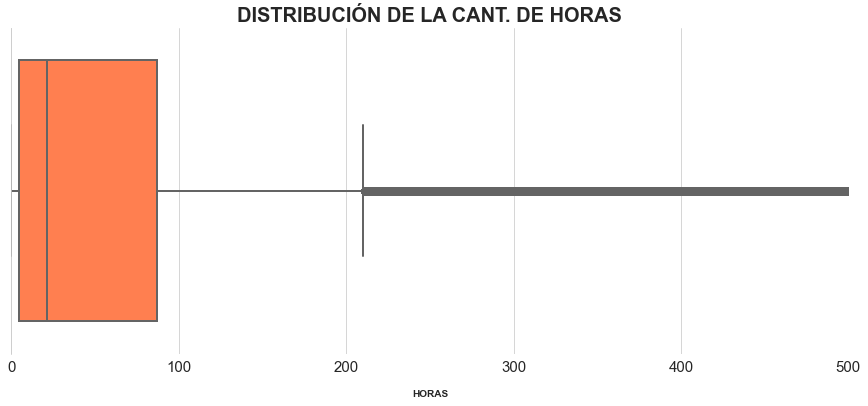

In [404]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Cant. horas', data=data, color='Coral', linewidth=2, saturation=1)
plt.title('Distribución de la cant. de horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xlim(0,500)
sns.despine(bottom=True)
plt.show()

Como se observa, tenemos una *distribución con asimetría positiva*, *la mediana es menor a un día*; también se observa una *gran presencia de outliers*. Completamos el gráfico anterior realizando una ***comparación de las distribuciones de las cantidad de horas de los usuarios según el acceso anticipado***.

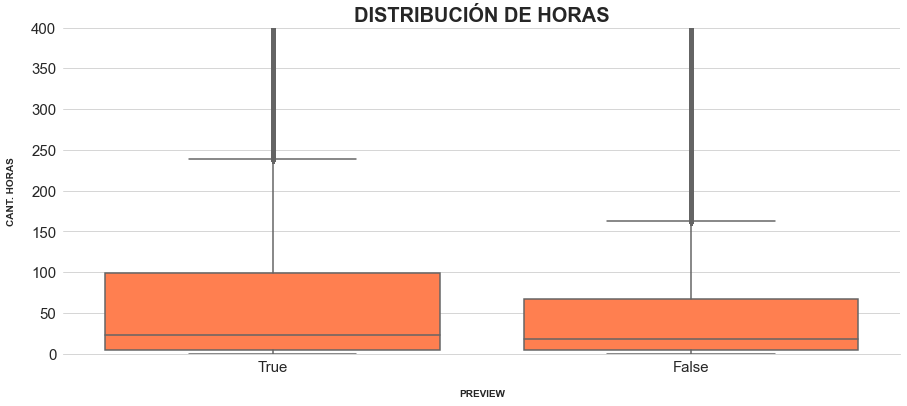

In [447]:
plt.figure(figsize=(15,6))
plt.title(f'Distribución de horas'.upper(), fontsize=20, fontweight='bold')
sns.boxplot(x='Preview', y='Cant. horas', data=data, color='Coral', order=[True, False], saturation=1)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Preview'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel(f'Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylim(0,400)
sns.despine(left=True)
plt.show()

Como se puede observar, los usuarios que si accedieron al preview de los productos tienen una mayor distribución en la cantidad de horas, esto nos da un indicio como funcióna la estrategia en los usuarios. Continuamos nuestro análisis discriminando aquellos usuarios que realizaron ***comentarios en productos con acceso previo pero este lo hizo en distintas instancias***, o sea, usuarios que comentaron alguna vez en etapas iniciales de algún juego y en etapas finales de otros.

In [428]:
table = data.pivot_table(index='Usuario', columns='Preview', values='GameID', aggfunc='count')
mask = (table.iloc[:,0] > 1) & (table.iloc[:,1] > 1)
idx = table[mask].index
users = reviews_games.query('Usuario in @idx')

#cols = ['Acceso previo', 'Preview']
summary_users = users.pivot_table(index=['Usuario'], columns='Preview', values='Cant. horas').agg(['sum', 'mean', 'count'])
summary_users.rename(index={ 'sum': 'Acumuladas', 'mean': 'Promedio', 'count': 'Total usuarios' }, inplace=True)
plot = summary_users.T
#plot.index.rename(names=cols, inplace=True)
plot.index.rename(name='Preview', inplace=True)

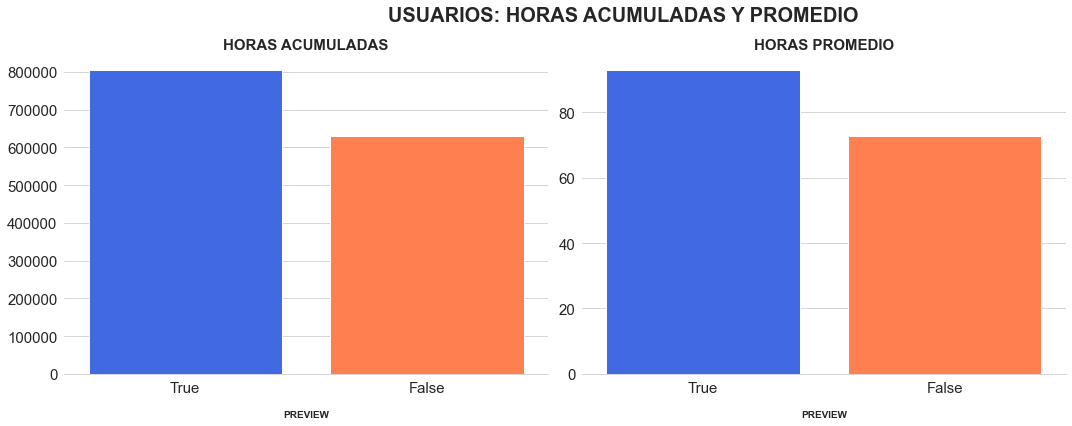

In [433]:
col = ['Acumuladas', 'Promedio']

fig, axs = plt.subplots(1, 2, figsize=(15,6), tight_layout=True)
fig.suptitle('Usuarios: Horas acumuladas y promedio'.upper(), x=.58, fontsize=20, fontweight='bold')
for x in range(0,2):
    var = col[x]
    sns.barplot(y=var, x='Preview', data=plot.reset_index(), palette=['Royalblue', 'Coral'], order=[True, False],
                saturation=1, ax=axs[x])
    axs[x].set_title(f'Horas { var }'.upper(), fontsize=15, fontweight='bold')
    axs[x].set_ylabel('')
    axs[x].set_xlabel('Preview'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
sns.despine(left=True)
plt.show()

El comportamiento de los usuarios que participan activamente en los productos, cuando este pone en marcha el acceso previo al mismo, nos dice que estos pasan mayor tiempo utilizando los mismos, son usuarios proactivos en el uso de los productos.

A continuación vemos como afecta el precio de los productos a los usuarios.

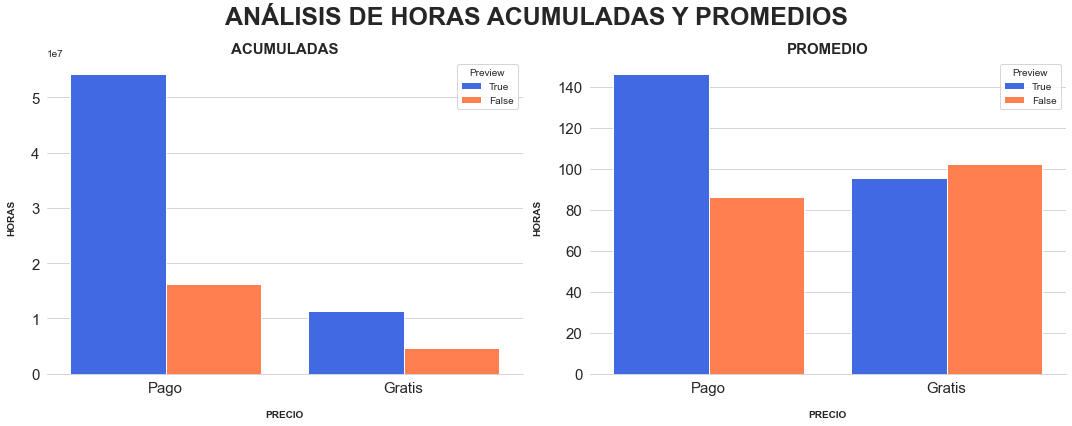

In [434]:
plot = data.groupby(by=['Precio', 'Preview'])['Cant. horas'].agg(['sum', 'mean'])\
           .rename(columns={ 'sum': 'Acumuladas', 'mean': 'Promedio' })
plot['Acumuladas']/24
plot.reset_index(inplace=True)

var = ['Acumuladas', 'Promedio']
fig, axs = plt.subplots(1,2, figsize=(15,6), tight_layout=True)
for x in range(0,2):
    func = var[x]
    sns.barplot(x='Precio', y=func, data=plot, palette=['Royalblue', 'Coral'], hue='Preview', hue_order=[True, False],
                order=['Pago', 'Gratis'], saturation=1, ax=axs[x])
    axs[x].set_title(f'{ func }'.upper(), fontsize=15, fontweight='bold')
    axs[x].set_xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
fig.suptitle('Análisis de horas acumuladas y promedios'.upper(), fontsize=25, fontweight='bold')
sns.despine(left=True)
plt.show()

De la imagen previa podemos observar como los usuarios que acceden a un avance de un producto son los que mayor tiempo invierten en la plataforma, se puede inferir que son usuarios corrientes en el mundo gamer, que disfrutan de los productos, los estrujan, para luego pasar al siguiente; para estos usuarios, el precio, no es una barrera para el entretenimiento. Un dato adicional, el promedio de horas de los usuarios sin optar por el anticipo de un producto, es similar al de los usuarios que sí lo hicieron, pero el de estos últimos es menor.

In [437]:
table = data.pivot_table(index='GameID', columns='Preview', values='Usuario', aggfunc='count')
idx_true = table.sort_values(by=True, ascending=False).index
idx_false = table.sort_values(by=False, ascending=False).index

In [438]:
# Juegos con mayor cantidad de usuarios que ingresaron al accceso previo.
preview_true = data.query('GameID in @idx_true & Preview == True')
preview_true = preview_true.pivot_table(index='GameID', values='Cant. horas', aggfunc=['sum', 'mean'],
                                        fill_value=0).rename(columns={'sum': 'Acumuladas',
                                                                      'mean': 'Promedio'}).fillna(0)
preview_true = preview_true.merge(games.loc[:,['GameID', 'Aplicación']], how='inner', left_on='GameID',
                                  right_on='GameID')
preview_true.rename(columns={ ('Acumuladas', 'Cant. horas') : 'Acumuladas',
                              ('Promedio', 'Cant. horas') : 'Promedio' }, inplace=True)

# Juegos con menor cantidad de usuarios que ingresaron al accceso previo estando esta disponible.
preview_false = data.query('GameID in @idx_false & Preview == False')
preview_false = preview_false.pivot_table(index='GameID', values='Cant. horas', aggfunc=['sum', 'mean'],
                                          fill_value=0).rename(columns={'sum': 'Acumuladas',
                                                                        'mean': 'Promedio'}).fillna(0)
preview_false = preview_false.merge(games.loc[:,['GameID', 'Aplicación']], how='inner', left_on='GameID',
                                    right_on='GameID')
preview_false.rename(columns={ ('Acumuladas', 'Cant. horas') : 'Acumuladas',
                              ('Promedio', 'Cant. horas') : 'Promedio' }, inplace=True)

# Merge de datos
suffixes = ('WithPreview', 'NoPreview')
plot = preview_true.loc[:, ['GameID', 'Aplicación', 'Acumuladas', 'Promedio']]\
                   .merge(preview_false.loc[:,['GameID', 'Acumuladas', 'Promedio']], how='left',
                          left_on='GameID', right_on='GameID', suffixes=suffixes).fillna(0)
plot.set_index('GameID', inplace=True)

C:\Users\Mr. Robot\.conda\envs\dataScience\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Mr. Robot\.conda\envs\dataScience\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


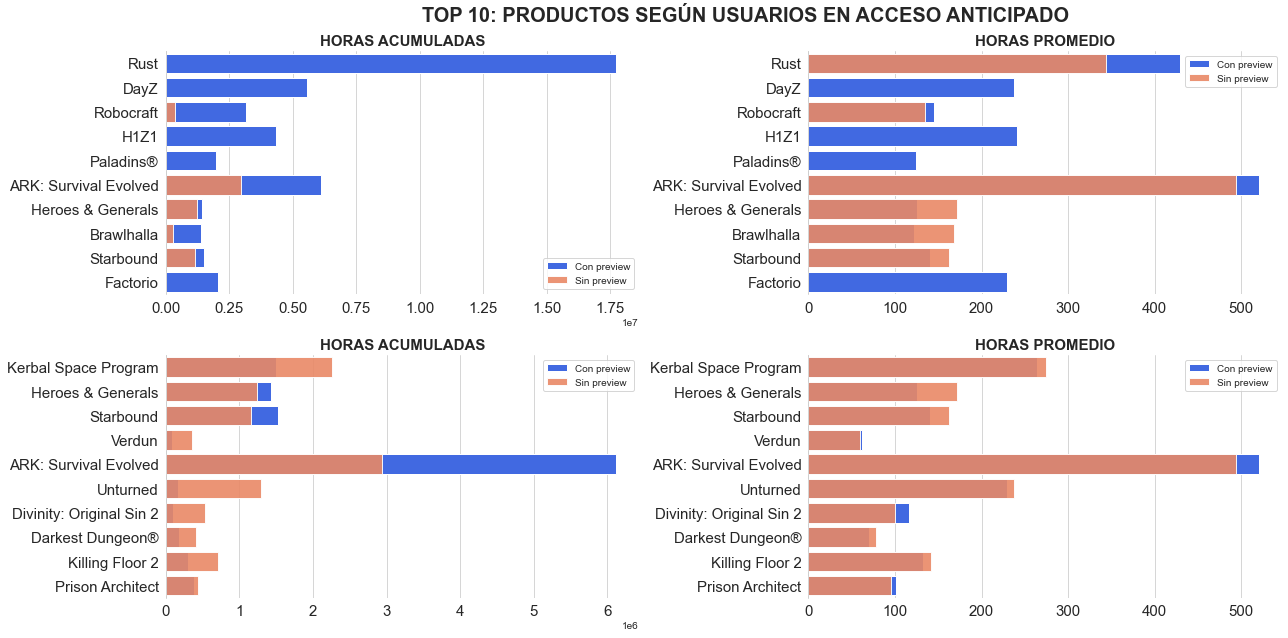

In [439]:
acumuladas = ['AcumuladasWithPreview', 'AcumuladasNoPreview', 'Horas acumuladas']
promedios = ['PromedioWithPreview', 'PromedioNoPreview', 'Horas promedio']

fig, axs = plt.subplots(2, 2, figsize=(18,9), tight_layout=True)
fig.suptitle('Top 10: Productos según usuarios en acceso anticipado '.upper(), x=.58, fontsize=20, fontweight='bold')
for x in range(0,2):
    for y in range(0,2):        
        row = acumuladas if y < 1 else promedios
        idx = idx_true if x < 1 else idx_false
        my_data = plot.loc[idx].head(10)
        sns.barplot(y='Aplicación', x=row[0], data=my_data, color='Royalblue', label='Con preview', saturation=1, ax=axs[x][y])
        my_data = plot.loc[idx].head(10)
        sns.barplot(y='Aplicación', x=row[1], data=my_data, alpha=.9, color='Coral', label='Sin preview', ax=axs[x][y])
        axs[x][y].legend(fontsize=10)
        axs[x][y].set_title(f'{ row[2] }'.upper(), fontsize=15, fontweight='bold')
        axs[x][y].set_ylabel('')
        axs[x][y].set_xlabel('')
        axs[x][y].tick_params(labelsize=15)
sns.despine(bottom=True)        
plt.show()

Como se puede observar, existen juegos donde las horas acumuladas y el promedio de horas de los usuarios que no tuvieron acceso a la preview es mayor a la de usuarios que si optaron por acceder en las etapas previas de desarrollo; en el gráfico es posible distinguir la difencia que existe entre estos usuarios.

---
**TOP 10: Juegos con mayor promedio de horas**

---

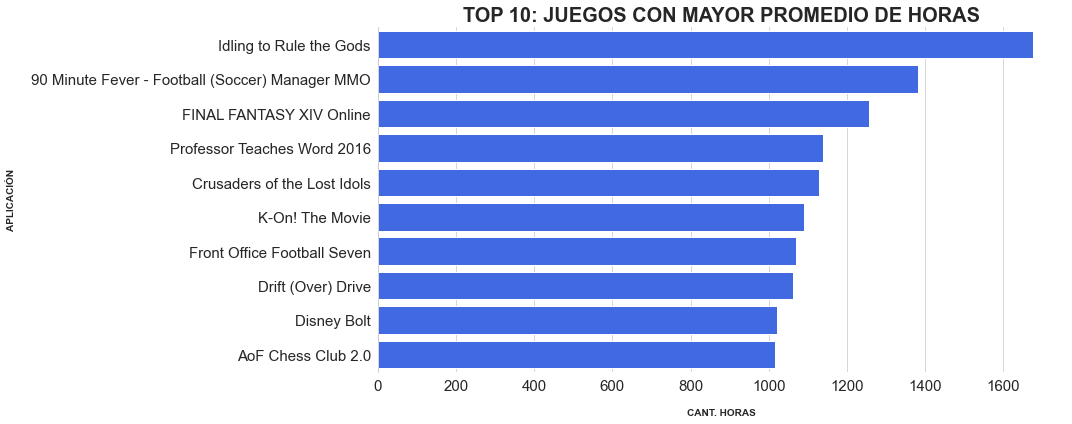

In [450]:
data = reviews_games.pivot_table(values=['Usuario', 'Cant. horas'], index=['GameID', 'Aplicación'],
                                 aggfunc={ 'Usuario': 'count', 'Cant. horas': np.mean }).sort_values('Cant. horas',
                                                                                                     ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

plt.figure(figsize=(15,6), tight_layout=True)
sns.barplot(x='Cant. horas', y='Aplicación', data=data, color='Royalblue', saturation=1)
plt.title('TOP 10: Juegos con mayor promedio de horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

---
**Análisis de las horas respecto al TOP 10 de juegos con mayor promedio de horas**

---

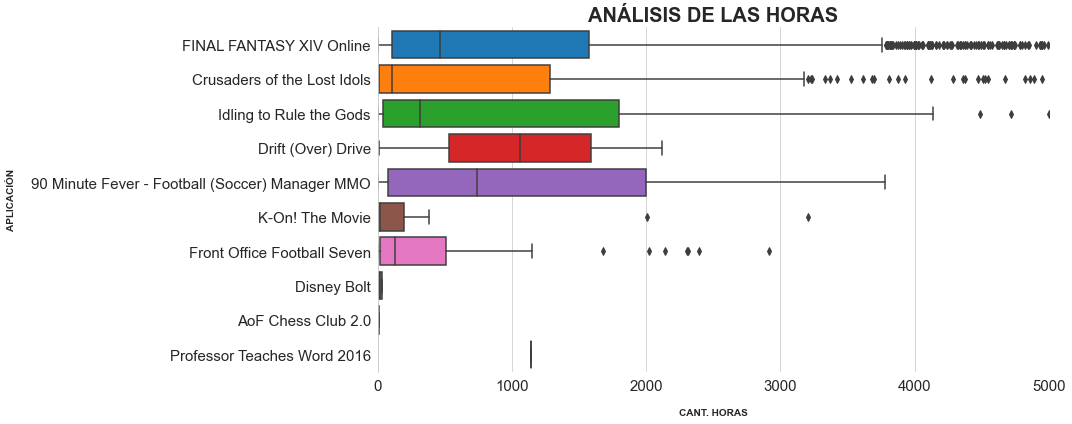

In [451]:
idx = data.GameID
mask = reviews_games['GameID'].isin(idx)
reviews_games[mask]

plt.figure(figsize=(15,6), tight_layout=True)
sns.boxplot(y='Aplicación', x='Cant. horas', data=reviews_games[mask], saturation=1)
plt.title('Análisis de las horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xlim(0,5000)
plt.ylabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

In [485]:
comments = reviews_games.query('GameID in [ 447920, 340990, 385020 ]').loc[:,['Aplicación', 'Comentario']].sample(5).values

for app, comment in comments:
    print(f'{ app }'.upper())
    print(f'------------------------------')
    print(f'{ comment }')
    print(f'--------------------------------------------------')
    print(f'--------------------------------------------------\n')

DISNEY BOLT
------------------------------
This is a good game but get it when it is on a sale. I enjoyed it if you feel like trying it out you should do it.
--------------------------------------------------
--------------------------------------------------

DRIFT (OVER) DRIVE
------------------------------
ṁ̵̺̥͔̀̐́͗͛̋̍̚͝y̸͖͉͈͇̓̾̋̾̾̇͒͋̓̆̚̚͘͘ ̸̧͚̹̼̰̌̍̎̚ć̵̛̺̮͕̪̺̜̼̖͙͕͙̣̞̬̽̈͂̀̎̈́̈̔o̷̖̹̟͑̒̌̃̂̋̐́̓̚͜͝͠m̷̛͈̦͍͗̈́̏̃̍͝p̴̨͉͔̟͍̔̽͘͠u̶̧͎͋͌̇̑̚ͅt̴̛̼̗̝͑̒̀̒͊́̉̃̕͜ḛ̶̢̢̛̫͍̏̏͗̈͐̀̓̾̃͂̈́̎̚ŗ̸̡̱̦͍͍̼̭̮͇̹̃̏͊̈̌͊́͒̃͋̕̚͜͠͝ ̶̰͔̺̜̜̫̪͖̳̩̣̲̃͒̓͑͌̉͊̏́̌̕̚̕͝ẖ̴͈̗̝͚͙͓̖̀̊́̄̋̆͐̊̌̄á̶̢̡̞̖̫͓̹͖͙͔̹̩̏̽̇̽̊̋̔̈͆̚͘͝ͅs̸̪̆̾͐̅̾̿̄̄̆͆̇̃̋̈̀ ̷̧̧̙̫͇̱̻̦̥̖̱̭̻́̇̔͊̉̀̔̈͑͗̏͘͝ͅb̷̡̮͙͉͎͔͖͙̖̰̀̄̂̒̎̂̀̄̆̿̚ę̴̡̥̱͖̎é̸̡̫̘̦͚̪͈͑̈̇̆̍̃n̴͙̐͆̓͗̀̔̏̔̚̚̚ ̴͎͎̫̄͌͊̃̚̚ǫ̷̧̘͎̗̪̯̥͔̺͚͚̃̅̓͊̀͊̌͜͝v̶̧̳̤̩̳̼̼͖͔͈̾̃̎̒͒ẽ̴̩̒́̊̈̋͑͝r̵̢̞̻̮̞̿͒ẗ̴̡̛̛̪̼̻̖̭̙͐͑̇͊̿̈́̋̉͝͝a̷̫̫̰͕͚̞̖͈̺͊̀̐͂̿̈̉̇̉́ͅk̵̳̻̺̩̒͑̏̈̒͗͐̓͐e̴̢͍̻̫͖̻͕͔̳̱̠͍̰̊̿̍̈̚ͅǹ̶̜̱̙̦̇̓͜ ̶̧̬̭͚̑͊̎̃͌̿̕b̷̮̭̗̭̺̰̪͛͒͆̀̀̈́̈́͜͝͝y̸̡̤͓̫͍̻͇̝̟̺̱̫͚̽̈́͘͜͝ͅ ̶͙͔̍͛͐̈̓͗̀̇̽̓r̵̥̝͖̈́̑͊͌͛̈́u̷͓͔̯̞̻͊͌̈́̐͝s̴̘̠͉̼̩̫̟̥̄̌̒ͅś̷̡̘̼̩̬̞̠̱͈̥̹͙̞̹̒̈̄̚ī̴̧̘͓̻̝̮̩̣͔̝̺̯̎̍̽̀̋̓̋̓̇ͅä̵̓̋̑

En los comentarios se puede observar que mayoritariamente existen reseñas negativas en estos juegos. Respecto al gráfico, hay que destacar, en relación al que corresponde a nuestro *TOP 10: Juegos con mayor promedio de horas*, que el juego con más comentarios no es el que tiene un promedio mayor de horas.

---
**TOP 10: Juegos con más comentarios discrimando el precio**

---

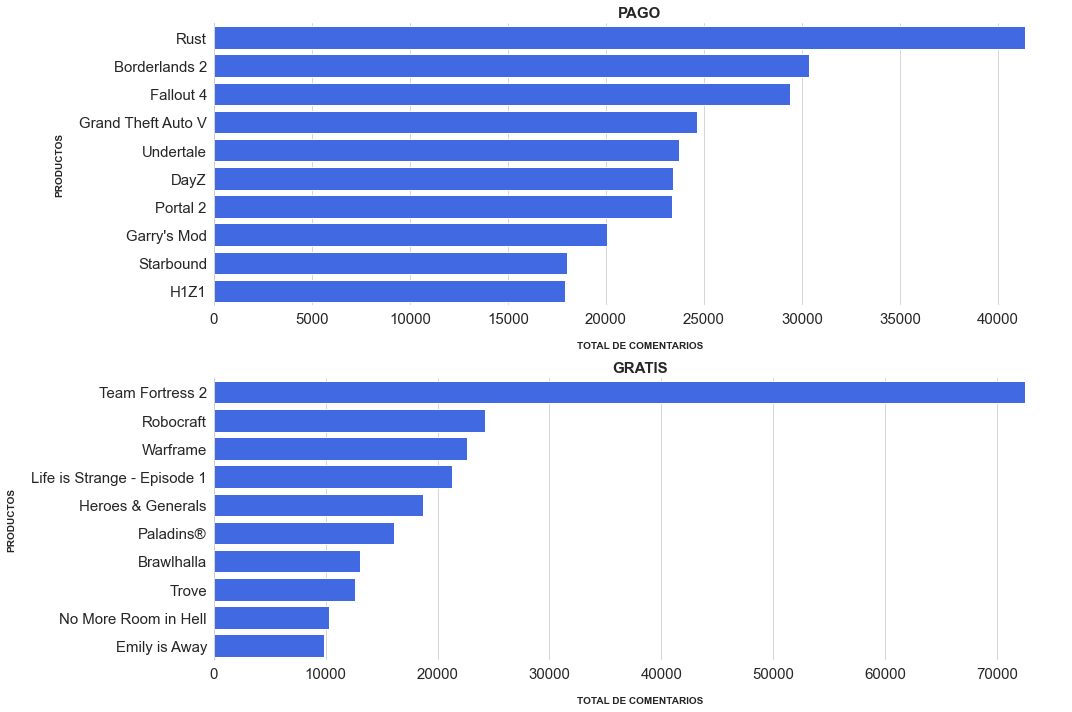

In [493]:
tipo_precio = ['Pago', 'Gratis']

fig, axs = plt.subplots(2, 1, figsize=(15,10), tight_layout=True)
for x in range(0,2):
    precio = tipo_precio[x]
    data = reviews_games.query('Precio == @precio').groupby('Aplicación').agg(Usuarios=pd.NamedAgg(column='Usuario', aggfunc='count'))\
                                                                         .sort_values('Usuarios', ascending=False)    
    data.reset_index(inplace=True)

    sns.barplot(x='Usuarios', y='Aplicación', data=data.head(10), color='Royalblue', saturation=1, ax=axs[x])
    axs[x].set_title(f'{ precio }'.upper(), fontsize=15, fontweight='bold')
    axs[x].tick_params(axis='both', labelsize=15)
    axs[x].set_xlabel('Total de comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Productos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

---
**Proporcionalidad de comentarios conforme a precio del videojuego**

---

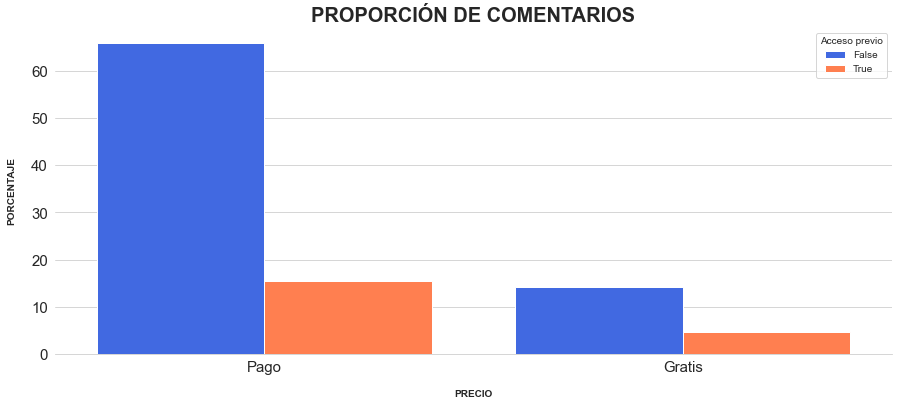

In [494]:
data = reviews_games.groupby(['Precio', 'Acceso previo']).agg(Usuarios=pd.NamedAgg(column='Usuario',
                                                                                   aggfunc=lambda x:len(x)/len(reviews_games)*100))
data.reset_index(inplace=True)

plt.figure(figsize=(15,6))
sns.barplot(x='Precio', y='Usuarios', data=data, palette=['Royalblue', 'Coral'], hue='Acceso previo', order=['Pago', 'Gratis'],
            saturation=1)
plt.title('Proporción de comentarios'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

Más del 80% comentarios corresponden a productos que son pagos, dentro de los cuales, más del 70% adquirió el juego sin pasar por una *preview*. También, se pude destacar que el acceso previo a los productos de la plataforma es una práctica orientada a productos pagos, incitando a los usuarios que adquieran los mismos cuando estén a la venta. Aquí sería interesante conocer cuantos de aquellos productos fueron finalmente una venta.

En base a estos últimos gráficos podemos entender que la gente es más propensa a realizar comentarios y críticas a productos pagos antes que aquellos que son gratis, en este punto no debemos olvidar que el producto con más comentarios es un videojuego gratuito.

Entiendo que una causa puede ser que nos es más fácil juzgar, o al menos nos sentimos con más derecho/obligación como usuario, aquello que nos implica un esfuerzo adicional, por ejemplo, antes de invertir dinero solemos pasar por un proceso de selección e investigación y resulta frustante si el mismo no llega a nuestras espectativas. Por lo tanto, es más probable que hagamos un comentario sobre un producto pago que no nos gusta, no disfrutamos, o no nos llena como usuarios; en caso de que el mismo cumpla nuestras espectativas, lo entendemos como un resultado lógico, ya que hemos pasado un tiempo analizado una variedad de productos, hemos buscado información para finalmente decantarnos y desembolsar nuestro dinero en algo que presuponemos que es de nuestra simpatía. 

De todos modos, es una conjetura y para poder encontrar una respuesta, debemos indagar con más detalle por lo que solo nos resta continuar en nuestro análisis.

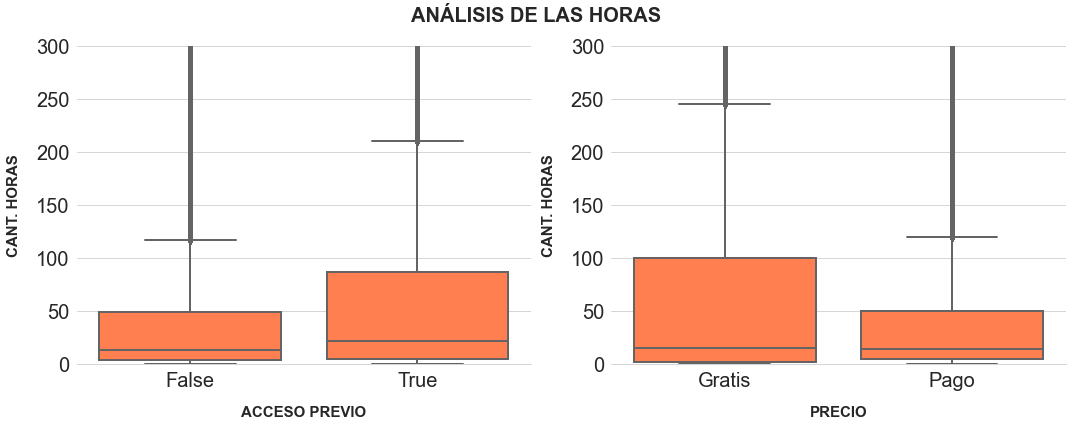

In [102]:
var = ['Acceso previo', 'Precio']

fig, axs = plt.subplots(1, 2, figsize=(15,6), tight_layout=True)
fig.suptitle('Análisis de las horas'.upper(), fontsize=20, fontweight='bold')
for x in range(0,2):
    func = var[x]
    sns.boxplot(x=func, y='Cant. horas', data=reviews_games, color='Coral', linewidth=2, saturation=1, ax=axs[x])
    axs[x].tick_params(axis='both', labelsize=20)
    axs[x].set_ylabel(f'Cant. horas'.upper(), fontsize=15, fontweight='bold', labelpad=15)
    axs[x].set_xlabel(f'{ func }'.upper(), fontsize=15, fontweight='bold', labelpad=15)
    axs[x].set_ylim(0,300)
sns.despine(left=True)
plt.show()

Como podemos observar en el gráfico de la distribución de las horas que pasan los usuarios utilizando algún producto, lo primero que llama la atención es que, en aquellos productos que son gratuitos, la misma es mayor. Lo mismo ocurre con aquellos productos a los que se pudo acceder a una *preview* del mismo, los usuarios pasan más tiempo en aquellos productos que ya conocen *—debido a la preview del mismo—* y es muy probable que sí el juego no gustó, los usuarios de dichos productos desistan probarlo una vez que finalizao la preview del mismo *—hay que tener en cuenta que muchos productos tienen costo, una experiencia fallida en el acceso anticipado al producto puede ser fatal para posteriormente concretar una venta—*.

Aquí cabe señalar que no sabemos como es el acceso a la preview de los productos, por lo tanto, no sabemos si corresponden a un selecto grupo de usuarios, si es al azar, etc. Esta carencia de información nos puede inducir a un error si no actuamos con cautela.

Continuamos buscando información, investigamos aquellos juegos que son pagos y tienen acceso previo para los usuarios.

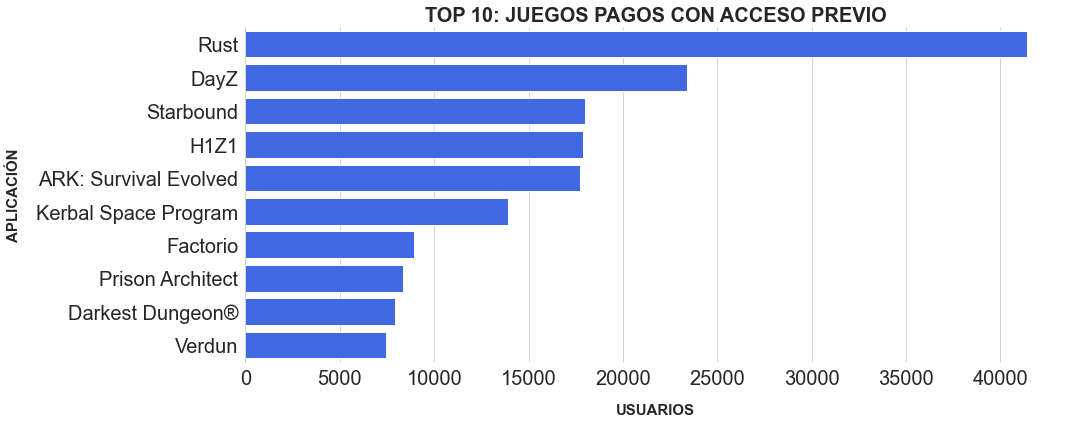

In [110]:
mask = (reviews_games['Acceso previo'] == True) & (reviews_games['Precio'] == "Pago")
data = reviews_games[mask].groupby(['GameID', 'Aplicación'])['Usuario'].count().sort_values(ascending=False)
data = data.reset_index()

plt.figure(figsize=(15,6), tight_layout=True)
sns.barplot(x='Usuario', y='Aplicación', data=data.head(10), color='Royalblue', saturation=1)
plt.title('Top 10: Juegos pagos con acceso previo'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=20)
plt.xlabel('Usuarios'.upper(), fontsize=15, fontweight='bold', labelpad=15)
plt.ylabel('Aplicación'.upper(), fontsize=15, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

Analizamos como se comportan los usuario teniendo en cuenta el precio de los juegos y el acceso previo.

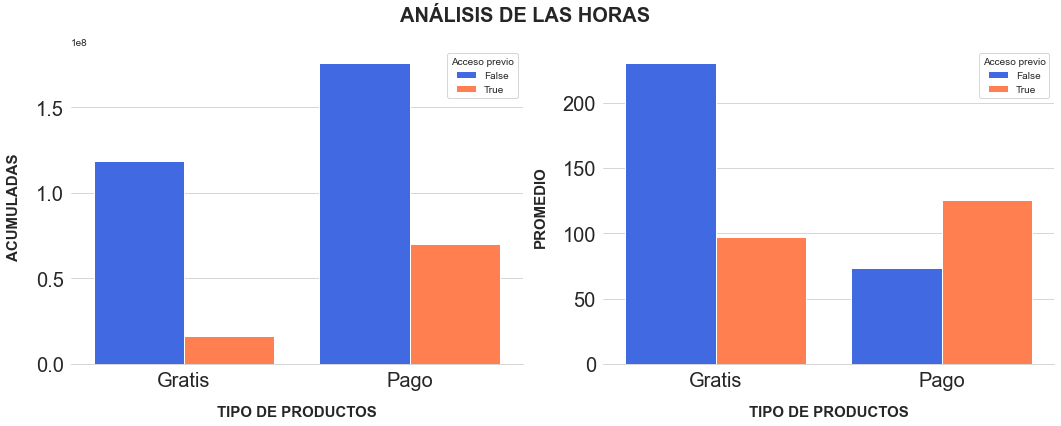

In [111]:
cols = ['Acumuladas', 'Promedio']
data = reviews_games.groupby(by=['Precio', 'Acceso previo'])['Cant. horas'].agg(['sum', 'mean']).rename(columns={'sum': 'Acumuladas',
                                                                                              'mean': 'Promedio'})
data.reset_index(inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(15,6), tight_layout=True)
fig.suptitle('Análisis de las horas'.upper(), fontsize=20, fontweight='bold')
for x in range(0,2):
    func = cols[x]
    sns.barplot(x='Precio', y=func, data=data.round(2), palette=['Royalblue', 'Coral'], hue='Acceso previo', saturation=1,
                ax=axs[x])
    axs[x].tick_params(axis='both', labelsize=20)
    axs[x].set_ylabel(f'{ func }'.upper(), fontsize=15, fontweight='bold', labelpad=15)
    axs[x].set_xlabel('Tipo de productos'.upper(), fontsize=15, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

**CONCLUSIÓN**

---

Analizando las horas que invierten los usuarios utilizando los distintos productos podemos observar que, si bien, en nuestro dataset contamos con más del 80% de comentarios sobre artículos que cuestan dinero, estos no generan satisfacción en los usuarios. Contrastando la proporción de comentarios sobre productos pagos con el promedio de horas utilizando los mismos, no sería apresurado decir que contamos con bastantes críticas negativas en nuestro dataset.

> Algo que debemos remarcar, *el promedio de horas de un usuario, con acceso previo a un determinado producto, el cuál a su vez no tiene costo, se corresponde al promedio de horas de un producto pago sin acceso previo*. Esto nos indica que **un usuario, luego de utilizar un producto por aproximadamente 75 horas (tres días y dos horas), puede evaluar este le gusta o no**, pasado este tiempo, si el mismo no lo satisface, este producto pasa al olvido.

Por lo tanto, refuerza nuestra hipotesís, los usuarios que deciden invertir dinero en un producto, son los que están más predispuestos a realizar un comentario sobre el mismo.

Esto contrasta con lo que sucede en `Netflix`, aquellos usuarios que no les agrada una serie o película son menos propensos a evaluar la misma. De todos modos, Netflix solo tiene una suscripción mensual para acceder al catálogo completo, algo que dista bastante del modelo de negocio que emplea `Steam`, donde el usuario debe pagar por un producto en particular que se encuentre disponible en la plataforma *—siempre que así se requiera—*.

---
**Total de comentarios por año**

---

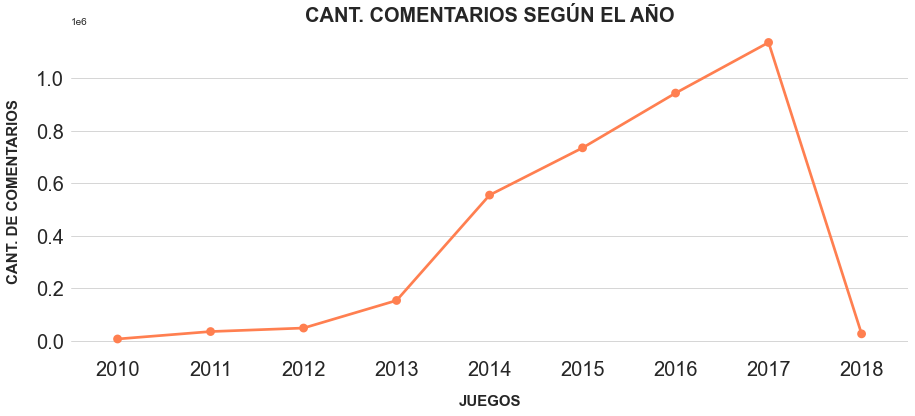

In [114]:
data = reviews_games.loc[:,['Usuario', 'Fecha', 'Comentario']]
data['Mes'] = data['Fecha'].dt.month_name()
data['Año'] = data['Fecha'].dt.year
group_year = data.groupby(by='Año').agg({ 'Comentario': 'count' })

plt.figure(figsize=(15,6))
sns.pointplot(x=group_year.index, y='Comentario', data=group_year, color='Coral', saturation=1)
plt.title('Cant. comentarios según el año'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=20)
plt.xlabel('Juegos'.upper(), fontsize=15, fontweight='bold', labelpad=15)
plt.ylabel('Cant. de comentarios'.upper(), fontsize=15, fontweight='bold', labelpad=15)
sns.despine(left=True, bottom=True)
plt.show()

La participación de los usuarios es lineal ascendente a medida que transcurre el tiempo, es nos marca como se fue afianzando la comunidad de steam participando en el foro.

---
**Mapa de calor para entender como se comportan los usuarios en el año discriminando los meses**

---

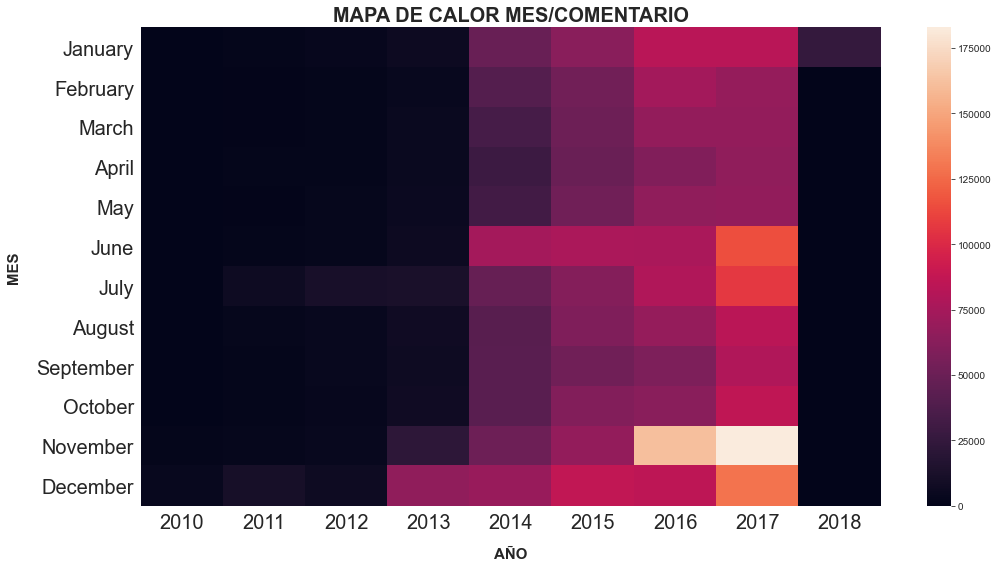

In [118]:
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 
         'December']
data_dates = data.groupby('Año')['Mes'].value_counts().unstack().fillna(0)[meses].T

plt.figure(figsize=(15,8), tight_layout=True)
plt.title('Mapa de calor mes/comentario'.upper(), fontsize=20, fontweight='bold')
sns.heatmap(data_dates)
plt.tick_params(labelsize=20)
plt.xlabel('Año'.upper(), fontsize=15, fontweight='bold', labelpad=15)
plt.ylabel('Mes'.upper(), fontsize=15, fontweight='bold', labelpad=15)
plt.show()
del data_dates

En este mapa de calor se puede observar como mes a mes aumenta la participación, en el foro, de forma gradual. En el año 2018 decae ya que no se recopilaron datos suficiente.

### Games


---
**Categorías que se encuentran en al menos el 5% de nuestros registros**

---

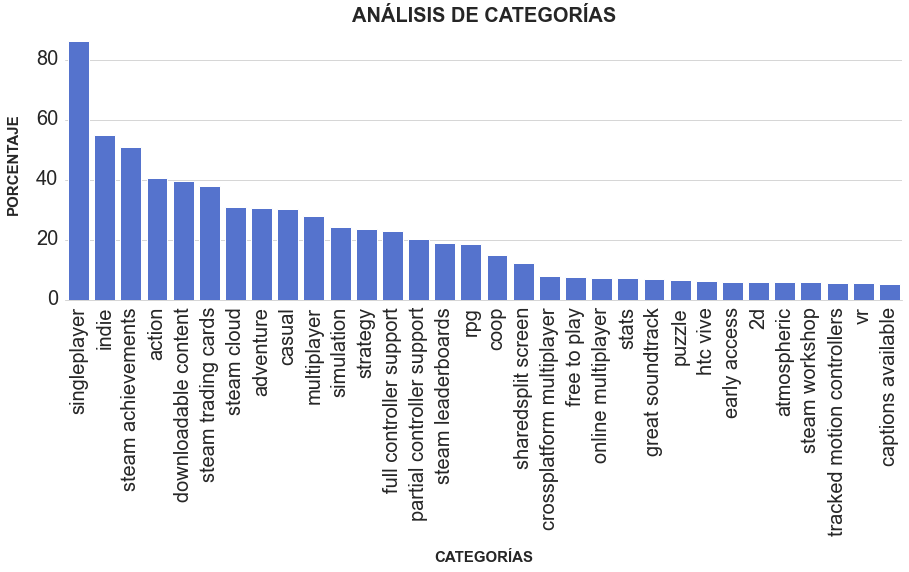

In [121]:
def one_dimension(series):
    return pd.Series([x for _list in series for x in _list], name='Categorías').value_counts()

data = one_dimension(games['Categorías']).apply(lambda x: x*100/len(games)).round(2)
mask = data.values > 5

plt.figure(figsize=(15,5))
sns.barplot(x=data[mask].index, y=data[mask].values, color='Royalblue')
plt.tick_params(axis='both', labelsize=20)
plt.title('Análisis de categorías'.upper(), fontsize=20, fontweight='bold')
plt.xlabel('Categorías'.upper(), fontsize=15, labelpad=15, weight='bold')
plt.xticks(ha='center', rotation=90)
plt.ylabel('Porcentaje'.upper(), fontsize=15, labelpad=15, weight='bold')
plt.yticks(va='center')
sns.despine(left=True)
plt.show()

Para mejorar nuestro modelo tenemos que deshacernos de algunos registros de productos donde los usuarios no lo usan con regularidad, esto se debe a que el juego no es interesante o el software no es lo que se esperaba.

In [39]:
summary_games = reviews_games.groupby('GameID')['Cant. horas'].aggregate(['count', 'sum', 'mean'])\
                                                              .rename(columns={'count': 'Usuarios',
                                                                               'sum': 'Total horas',
                                                                               'mean': 'Promedio'})
summary_games.head()

,Usuarios,Total horas,Promedio
GameID,,,
10,175,42013.500000,240.077133
20,1077,129606.203125,120.340019
30,783,132344.000000,169.021713
40,318,6008.799805,18.895597
50,1238,31121.199219,25.138288


Para poder realizar un filtrado de nuestro juegos, debemos analizar 

In [57]:
idx = summary_games['Promedio'].idxmax()
summary_games.loc[idx,:].round(2)

Usuarios          153.00
Total horas    256387.41
Promedio         1675.73
Name: 466170, dtype: float64

In [58]:
reviews_games.query('GameID == 466170')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,GameID,Aplicación,Acceso previo,Precio,Categorías
24132,Vorthod,129.300003,153.0,2018-01-01,I'm a sucker for idle games where you allocate...,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
48290,sesshoth,590.299988,2.0,2017-12-28,Fun way to waste time,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
93600,aidynmaster,872.900024,49.0,2017-12-19,Why should you play this game? 1. Because it ...,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
117022,Wungle,0.300000,617.0,2017-12-12,"Wow, you really have to dig in to know how to ...",466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
155454,Seneschul,17.400000,2243.0,2017-11-30,Not enough flashiness. Poor gui. Needs a lot o...,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
...,...,...,...,...,...,...,...,...,...,...
1763793,bobsthename,542.799988,24.0,2016-05-27,I've been playing this game on kongregate for ...,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
1763796,Kelvin Crawl,51.299999,235.0,2016-05-27,Killed Hyperion. 10/10 would kill Hyperion again.,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
1763797,The Real Slim Shayney,35.400002,1196.0,2016-05-27,This game is quite fun if you like idle games....,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."
1763798,jayxan,1.000000,508.0,2016-05-27,I'm glad its on steam for free! I never would ...,466170,Idling to Rule the Gods,False,Gratis,"[anime, casual, clicker, free to play, inapp p..."


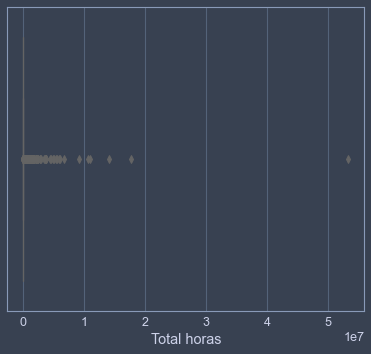

In [42]:
sns.boxplot(x='Total horas', data=summary_games, color='Coral')
plt.show()

In [230]:
summary_games.describe()

,sum,count,mean
count,1.489600e+04,14896.000000,14896.000000
mean,2.555104e+04,243.995838,19.531456
std,5.275899e+05,1281.072072,57.100170
min,0.000000e+00,1.000000,0.000000
25%,1.550000e+01,5.000000,2.363958
50%,1.062500e+02,18.000000,5.600000
75%,1.011750e+03,85.000000,14.535725
max,5.331766e+07,72523.000000,1675.734619


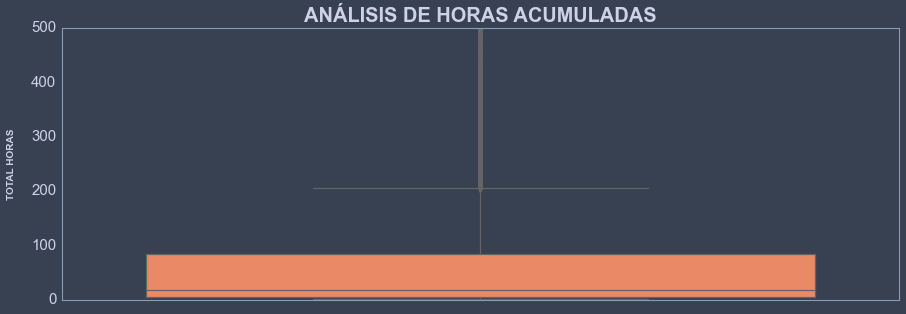

In [229]:
plt.figure(figsize=(15,5))
sns.boxplot(y='count', data=summary_games, color='Coral')
plt.tick_params(axis='both', labelsize=15)
plt.title('Análisis de horas acumuladas'.upper(), fontsize=20, fontweight='bold')
plt.ylabel('Total horas'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.yticks(va='center')
plt.ylim(0,500)
plt.grid(False)
plt.show()

In [190]:
summary_games.query('sum >= 24')

,sum,count,mean
GameID,,,
10,42013.500000,175,240.077133
20,129606.203125,1077,120.340019
30,132344.000000,783,169.021713
40,6008.799805,318,18.895597
50,31121.199219,1238,25.138288
...,...,...,...
758500,168.500000,34,4.955883
758990,33.200001,6,5.533333
763410,295.600006,245,1.206531


In [ ]:
summary_users = reviews_games.groupby('Usuario')['Cant. horas'].agg(['count', 'mean'])
round(summary_users['count'].quantile(0.7),0)

In [174]:
summary_users = reviews_games.groupby('Usuario')['Cant. horas'].agg(['count', 'mean'])
#round(summary_users['count'].quantile(0.7),0)
summary_users.describe()

,count,mean
count,1.708420e+06,1.708420e+06
mean,2.127441e+00,1.351251e+02
std,4.816838e+00,4.148887e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,7.100000e+00
50%,1.000000e+00,2.476667e+01
75%,2.000000e+00,8.990000e+01
max,6.030000e+02,3.180730e+04


## **Sistemas de recomendación**

### Benchmark

Como modelo benchmark, podemos recomendar los videojuegos de nuestro TOP 10 donde los usuarios tienen mayor promedio de horas jugando.

Existen ocasiones donde un nuevo juego o artículo se estrena y este mismo no posee calificaciones; a esta situación se la denomina ***COLD START***. En este caso, por medio de los metadatos que conseguimos del juego o artículo en cuestión, generamos proximidad a otros juegos/artículos.

Este primer acercamiento, basado en un sistema de recomendación por contenido, nos sirve para poder generar recomendaciones a través de los metadatos que podemos encontrar en nuestro dataset de cada artículo.

In [35]:
games.reset_index(drop=True, inplace=True)
games.head()
dummies = games.apply(pd.Series).stack().str.get_dummies().sum(level=0)

SyntaxError: invalid syntax (<ipython-input-35-7278f4aa1c6f>, line 3)

In [136]:
categories = games['Categorías'].apply(pd.Series)
cols = categories.columns.tolist()
dummies = pd.DataFrame()
for col in cols:
    if dummies.empty:
        dummies = pd.get_dummies(categories[col])
    else:
        dummies.add(pd.get_dummies(categories[col]))

In [149]:
cat = data[mask].index
dummies.loc[:,cat.values]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['steam trading cards', 'steam cloud', 'steam leaderboards', 'puzzle',\n       'steam workshop', 'tracked motion controllers', 'vr'],\n      dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

Visualizamos el shape de nuestra matriz

In [112]:
dummies.drop(columns=[ 'Animation &amp; Modeling', 'Audio Production', 'Captions available', 'Commentary available',
                       'Design &amp; Illustration', 'Early Access', 'Includes Source SDK', 'Includes level editor',
                       'Mods (require HL1)', 'Mods (require HL2)', 'Partial Controller Support', 'Photo Editing',
                       'Seated', 'Software Training', 'Standing', 'Steam Turn Notifications', 'Video Production',
                       'Web Publishing' ], inplace=True)
dummies.shape

(30752, 43)

In [120]:
dummies.head()

,Action,Adventure,Casual,Co-op,Cross-Platform Multiplayer,Downloadable Content,Education,Free to Play,Full controller support,Game demo,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Workshop,SteamVR Collectibles,Strategy,Tracked Motion Controllers,Utilities,Valve Anti-Cheat enabled,Windows Mixed Reality
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


Generamos nuestra matriz de distancias utilizando la similitud del coseno.

In [118]:
similitudes = cosine_similarity(dummies, dummies, dense_output=False)
similitudes.shape

Creamos una función de recomendaciones

In [145]:
index = pd.Series(games['GameID'])
def recomendations(game_index, simil=similitudes):
    recomendations = []
    idx = index[index == game_index].index[0]
    scores = pd.Series(simil[idx]).sort_values(ascending=False)
    top_ten = list(scores.iloc[1:11].index)

    for i in top_ten:
        recomendations.append(list(games.Aplicación)[i])
    return recomendations

print(recomendations("706030"))

['the Breath.', 'Production Inc.', 'Finger Ninja', 'Puzzle Mania', 'Yatzy', 'Pony World 2', 'Solitaire', 'Dream Daddy: A Dad Dating Simulator', 'Retro Pinball', 'Joy Pony']


En este sistema de recomendación basado en contenido no tomamos en cuenta ningún tipo de calificación que cada usuario realiza sobre un juego, únicamente nos basamos en el contenido y los metadatos intrínsecos de cada videojuego.

### Sistema de recomendación: Basado en contenido

Implementamos un motor de recomendación utilizando un filtro basado en contenido. Hacemos uso de la librería ```Implicit```, la cuál, nos ayuda en una problemática que se puede ver a lo largo de todo nuestro análisis: carecemos de un puntaje explícito por parte de los usuarios.

#### Implicit ratings

De acuerdo al análisis de nuestros datos, corroboramos la ausencia de un rating o feedback explícito en formato número por parte de los usuarios. Contamos con dos aproximaciones a lo que se puede considerar un rating: *un feedback escrito* y un atributo donde *el usuario califica que tan divertido es un juego*, este no nos puede ayudar porque tiene mucha presencia de valores nulos.

In [32]:
samples = sample_without_replacement(method='auto', n_population=reviews_games.shape[0], n_samples=1000000,
                                     random_state=10)
rg = reviews_games.loc[samples,:]

In [33]:
horas = rg['Cant. horas'].values
scale = RobustScaler().fit_transform(horas.reshape(-1,1))
rg['Cant. horas SCALE'] = scale

In [40]:
reviews.query('Usuario == "null"')

,Usuario,Cant. horas,Cant. juegos,Acceso previo,Fecha,Comentario,GameID
194476,null,16.000000,214,False,2017-12-03,Great game to play during a boring college class.,410150
274843,null,252.600006,18,True,2017-11-15,"Great game, really fun mix of a card game and ...",648430
482046,null,9.400000,18,True,2017-10-08,nice,444090
269523,null,0.100000,33,False,2017-05-30,The pinnacle of incremental idle games.,612020
100118,null,0.500000,33,False,2017-04-18,The level design makes no sense and the boss f...,560260
801231,null,4.000000,67,True,2017-04-16,I'm going to preface this by saying I only hav...,362490
47216,null,0.900000,348,False,2017-03-17,very relaxing,461560
1516624,null,8.500000,71,False,2017-03-16,It's hilarious and also the story is top notch,620
1887828,null,36.500000,27,True,2017-03-03,"terrible overal experience. hacks, slow server...",433850
1502461,null,8.000000,25,True,2017-02-28,"I don't usually write reviews, but i have to w...",431960


Tomamos 1.000.000 de registros para evitar problemas en el procesamiento de nuestros datos. Creamos matrices dispersas utilizando la cantidad de horas que un usuario pasa en un juego como punto de partidad para establecer un interés del mismo con un juego/producto, lo basamos en la premisa de que si un juego no es divertido uno no lo juega.

Creamos nuestras matrices dispersas.

In [34]:
sparse_item_user = sparse.csr_matrix((rg['Cant. horas SCALE'], (rg['GameID'], rg['Usuario'])))
sparse_user_item = sparse.csr_matrix((rg['Cant. horas SCALE'], (rg['Usuario'], rg['GameID'])))

TypeError: 'str' object cannot be interpreted as an integer

Instanciamos un modelo ALS.

In [39]:
alpha = 15
train, test = evaluation.train_test_split((sparse_item_user*alpha).astype('double'), train_percentage=.66)

als = AlternatingLeastSquares(factors=20, iterations=25, random_state=10, regularization=.1)
als.fit(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Evaluamos nuestro modelo con la métrica *AUC*.

In [41]:
auc = evaluation.AUC_at_k(als, train, test, show_progress=False)
print('AUC: %s' %round(auc, 4))

AUC: 0.5


Obtenemos un valor de **AUC de 0.5**. Este valor nos da la pauta que nuestro modelo está realizando predicciones sin sustento en los datos.

Creamos una función para obtener las recomendaciones utilizando el algoritmo ALS.

In [68]:
def recomendaciones(usuario):
    #user_items = sparse_user_item.T.tocsr()
    recom = als.recommend(usuario, sparse_user_item, 10)
    idx = [r[0] for r in recom]
    scr = [r[1] for r in recom]
    apps = games.query('GameID == @idx').Aplicación
    print(recom)
    print(pd.DataFrame(scr, index=apps, columns=['Score']))

Únicamente, lo que resta es buscar un juego y obtener las recomendaciones.

In [69]:
recomendaciones(1485702)

[(440, 1.761849e-10), (363970, 9.6991165e-11), (107410, 8.2708985e-11), (391540, 7.351661e-11), (306130, 4.0549463e-11), (204300, 3.8454046e-11), (200210, 3.233617e-11), (221380, 3.2204895e-11), (211820, 3.0540633e-11), (294100, 2.7648623e-11)]
                                                      Score
Aplicación                                                 
Realm of the Mad God                           1.761849e-10
Clicker Heroes                                 9.699117e-11
Undertale                                      8.270899e-11
RimWorld                                       7.351661e-11
Starbound                                      4.054946e-11
The Elder Scrolls® Online: Tamriel Unlimited™  3.845405e-11
Arma 3                                         3.233617e-11
Age of Empires II HD                           3.220490e-11
Awesomenauts - the 2D moba                     3.054063e-11
Team Fortress 2                                2.764862e-11


In [53]:
rg.index

Int64Index([1139031, 2544479, 1123492, 1485702, 1304151, 2913157, 1653303,
            2920688, 1850523,  764911,
            ...
            3496560, 3106698,  273020, 2339627, 1406344, 2582688, 3108074,
            2866054, 1745285,  725238],
           dtype='int64', length=1000000)

In [70]:
rg.query('Usuario == "Astral"')

,Usuario,Cant. horas,Cant. juegos,Acceso previoREVIEWS_,Fecha,Comentario,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Acceso previoGAMES,Precio,Categorías,Cant. horas SCALE
975118,Astral,5.500000,263,False,2017-03-17,I went into it knowing nothing. It's a beautif...,481510,Night in the Woods,Infinite Fall,2017-02-21,False,Paid,"[2d, adventure, atmospheric, colorful, cute, d...",-0.174168
3633912,Astral,27.500000,611,False,2010-11-20,A very good classic game. If you enjoyed games...,32370,STAR WARS™ - Knights of the Old Republic™,"BioWare,Aspyr (Mac)",2003-11-19,False,Paid,"[action, adventure, atmospheric, choices matte...",0.256360
948504,Astral,1.700000,436,False,2017-03-29,"It feels like an uninspired, ground-based Sins...",507490,Ashes of the Singularity: Escalation,"Stardock Entertainment,Oxide Games",2016-11-10,False,Paid,"[benchmark, coop, futuristic, indie, multiplay...",-0.248532
228923,Astral,97.699997,97,False,2017-11-23,I'll just play one game. How long could it pos...,8930,Sid Meier's Civilization® V,"Firaxis Games,Aspyr (Mac, Linux)",2010-09-21,False,Paid,"[4x, classic, coop, diplomacy, economy, educat...",1.630137


In [116]:
# 219441, 758210, 94304, 326670
#final_data.isna().sum()
reviews_games[columns][reviews_games.Usuario.str.contains('[^\u0001-\u007F]{3,}')]

#username = reviews_games.Usuario.values
#username = reviews_games.Usuario.str.encode('utf-8')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,GameID,Aplicación,Géneros,Especificaciones
22,✦Димитрис✦,1.6,66.0,2018-01-05,"Fun game, wierdly addictive, would reccomend",217100,Dementium II HD,"[Action, Adventure, Indie]","[Single-player, Steam Achievements, Full contr..."
33,空白《叶秋》,254.0,19.0,2018-01-05,Very fun XD lmao,359550,Tom Clancy's Rainbow Six® Siege,[Action],"[Single-player, Multi-player, Co-op, Steam Tra..."
143,ШопскиСРБ,41.8,44.0,2018-01-05,Great survival game with good story !The game ...,242760,The Forest,"[Action, Adventure, Indie, Simulation, Early A...","[Single-player, Multi-player, Co-op, Steam Cloud]"
201,ℳ𝓻.𝓦𝓸𝓵𝒇𝓲𝒆,115.7,131.0,2018-01-05,"If you don't enjoy farming/grinding, this is n...",230410,Warframe,"[Action, Free to Play]","[Single-player, Multi-player, Co-op, Steam Tra..."
208,Неки лик,17.2,8.0,2018-01-05,"Tried to play 5 times, still cant get the feel...",230410,Warframe,"[Action, Free to Play]","[Single-player, Multi-player, Co-op, Steam Tra..."
...,...,...,...,...,...,...,...,...,...
3654541,Cyriel ᛭ᚲᛃᚱᛁᛖᛚ᛭,6.6,825.0,2010-11-02,Hell yes people. Just yes.,39800,Nation Red,"[Action, Indie]","[Single-player, Multi-player, Online Multi-Pla..."
3654543,Вежливый из Крыма (РФ),0.1,374.0,2010-11-01,That's an awesome game! Must Have! Played in 2...,11480,Soldiers: Heroes of World War II,[Strategy],"[Single-player, Multi-player, Co-op]"
3654640,Белый охотник,32.3,109.0,2010-10-17,i just love it!,630,Alien Swarm,[Action],"[Single-player, Multi-player, Co-op, Steam Ach..."
3654654,ﾚ҉.̠̪͎̯̮ͤ͛̋̀͆ͮ̐7,0.9,730.0,2010-10-17,Oddly entertaining.,11370,Nikopol: Secrets of the Immortals,"[Adventure, Indie]",[Single-player]


In [119]:
#print(reviews_games.Usuario.str.encode(encoding="utf-8"))
reviews_games[reviews_games['Usuario']=='null'].shape

(44, 17)